# Using Machine Learning Tools 2023, Assignment 3

## Sign Language Image Classification using Deep Learning

### Timo Brady

**A Custom-Built Stochastic Method with Structured Refinement for Artificial Neural Network Architecture Search and Optimization**

*   Implemented custom-built random searches across Densely-Connected Neural Network (DNN) and Convolutional Neural Network (CNN) architectures
*   Culled models based on primary performance criteria and overfitting checks
*   Validated the top 48 models via K-Fold Cross-Validation; refined to 25 via mean validation accuracy
*   Focused on stable performance, selecting 10 models with consistent F1 scores
*   Eliminated models with the most unstable learning curves
*   Calculated p-values to rigorously compare performances, applying Occam's razor: the least complex models were chosen when statistically indistinguishable

In [ ]:
!pip install pydot graphviz

import gdown
from google.colab import drive
import os
import gc

import pandas as pd
import numpy as np
import string
import random
import json
from pprint import pprint
import ast

from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

from mlxtend.evaluate import permutation_test
from statsmodels.stats.multitest import fdrcorrection

import tensorflow as tf
import keras
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules
from keras.models import load_model
from keras.layers import Reshape
from keras.utils import plot_model

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', dpi=100)
import seaborn as sns; sns.set()
import IPython.display as display
from PIL import Image

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

np.random.seed(42)

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATA LOADING, PRE-PROCESSING, AND REVIEW

In [ ]:
project_folder = "/content/drive/My Drive/Sign_Language"

In [ ]:
# SET UP THE PROJECT FOLDER
# DATA AND MODELS WILL BE SAVED HERE IN CASE OF RUNTIME INTERRUPTION

if not os.path.exists(project_folder):
    os.makedirs(project_folder)

In [ ]:
# DOWNLOAD THE SIGN LANGUAGE TRAINING DATA SET

output_path = os.path.join(project_folder, 'sign_mnist_train.csv')
file_id = ""
url = f"https://drive.google.com/uc?export=download&id={file_id}"
gdown.download(url, output_path, quiet=False)

In [ ]:
df_train_full = pd.read_csv(output_path)

In [ ]:
print(df_train_full.head())

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     153  ...       207       207       207       207       206       206   
1     158  ...        69       149       128        87        94       163   
2     187  ...       202       201       200       199       198       199   
3     210  ...       235       234       233       231       230       226   
4     185  ...        92       105       105       108       133       163   

   pixel781  pixel782  pixel783  pixel784  
0       206       204       20

In [ ]:
data_count = df_train_full.shape[0]
print(f"total number of items: {data_count}")

total number of items: 27455


In [ ]:
print(df_train_full["label"].value_counts())

17     1294
16     1279
11     1241
22     1225
5      1204
18     1199
3      1196
14     1196
19     1186
23     1164
8      1162
20     1160
13     1151
2      1144
0      1126
24     1118
10     1114
6      1090
15     1088
21     1082
12     1055
7      1013
1      1010
4       957
200       1
Name: label, dtype: int64


In [ ]:
# REMOVE ANOMALOUS LABEL 200 AND VERIFY

df_train_full = df_train_full[df_train_full["label"] != 200]
print(df_train_full["label"].value_counts())

17    1294
16    1279
11    1241
22    1225
5     1204
18    1199
3     1196
14    1196
19    1186
23    1164
8     1162
20    1160
13    1151
2     1144
0     1126
24    1118
10    1114
6     1090
15    1088
21    1082
12    1055
7     1013
1     1010
4      957
Name: label, dtype: int64


In [ ]:
# SPLIT DATA WITH STRATIFICATION

X_train_full = df_train_full.drop("label", axis=1).values
y_train_full = df_train_full["label"].values

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

In [ ]:
# DATA PRE-PROCESSING

pipeline = Pipeline([
    ('scaler', MinMaxScaler())
])

X_train_p = pipeline.fit_transform(X_train)
X_valid_p = pipeline.transform(X_valid)

In [ ]:
# VERIFY SCALING

print(f"min post scaling: {X_train_p.min()}")
print(f"max post scaling: {X_train_p.max()}")

min post scaling: 0.0
max post scaling: 1.0000000000000002


In [ ]:
# VERIFY INPUT SHAPE

unique_shapes = set([img.shape for img in X_train_p])
print(unique_shapes)

{(784,)}


In [ ]:
# LETTER MAPPING

label_to_letter = list(string.ascii_uppercase)
excluded_letters = ['J', 'Z']

mapping = {i: letter for i, letter in enumerate(label_to_letter) if letter not in excluded_letters}
print(mapping)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y'}


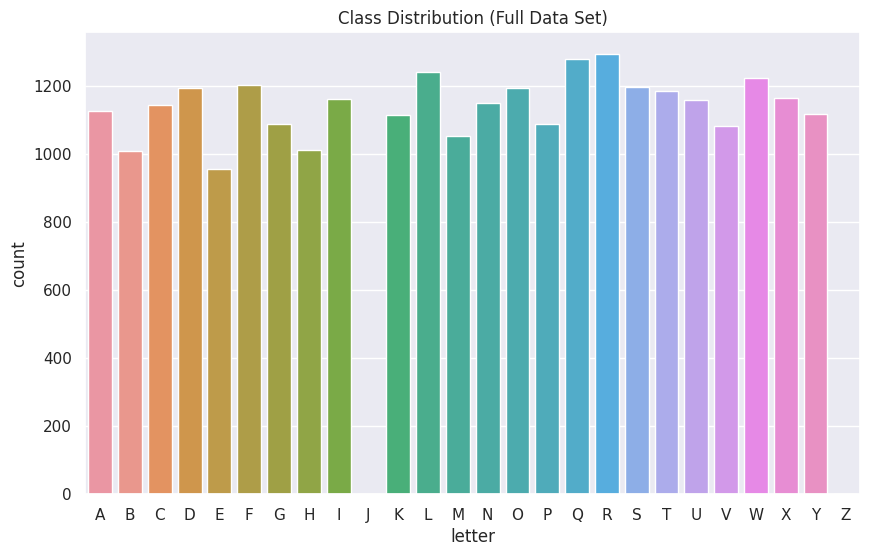

In [ ]:
df_train_full["letter"] = df_train_full["label"].apply(lambda x: mapping[x])

plt.figure(figsize=(10, 6))
sns.countplot(data=df_train_full, x="letter", order=label_to_letter)
plt.title("Class Distribution (Full Data Set)")
plt.xticks()
plt.show()

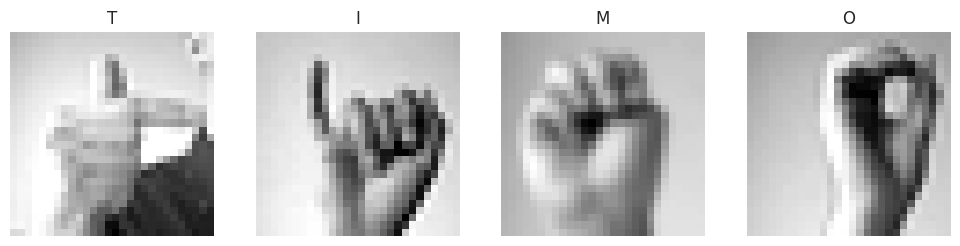

In [ ]:
word = "TIMO"
fig, axes = plt.subplots(1, len(word), figsize=(10, 2.5))
for idx, letter in enumerate(word):
    label = [k for k, v in mapping.items() if v == letter][0]
    image = X_train[y_train == label][0]

    axes[idx].imshow(image.reshape(28, 28), cmap='gray')
    axes[idx].set_title(letter)
    axes[idx].grid(False)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

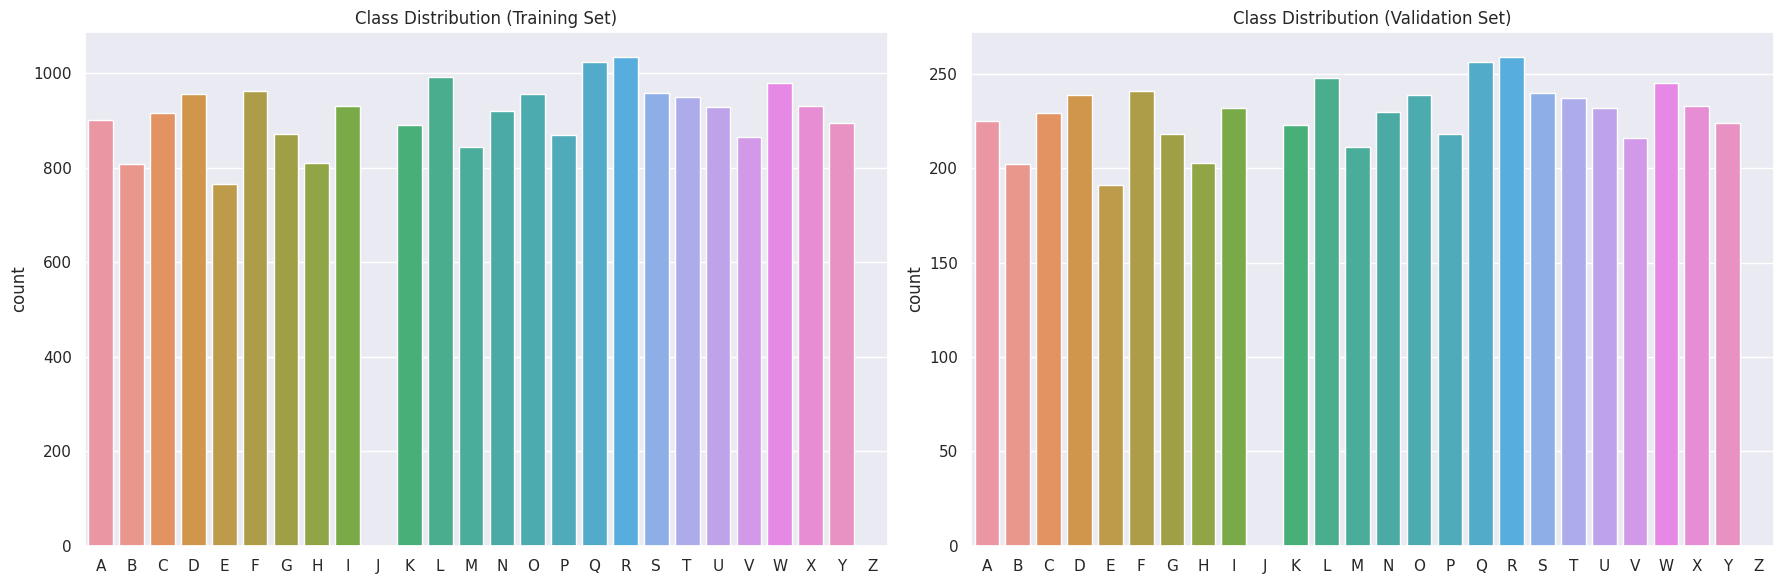

In [ ]:
y_train_letters = [mapping[label] for label in y_train]
y_train_series = pd.Series(y_train_letters)

plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train_series, order=label_to_letter)
plt.title('Class Distribution (Training Set)')
plt.xticks(ticks=np.arange(len(label_to_letter)), labels=label_to_letter)

y_valid_series = pd.Series([mapping[label] for label in y_valid])
plt.subplot(1, 2, 2)
sns.countplot(x=y_valid_series, order=label_to_letter)
plt.title('Class Distribution (Validation Set)')
plt.xticks(ticks=np.arange(len(label_to_letter)), labels=label_to_letter)

plt.tight_layout()
plt.show()

# DENSELY CONNECTED NEURAL NETWORK (DNN) FUNCTIONS

In [ ]:
# FUNCTION TO CONSTRUCT DENSLEY CONNECTED NEURAL NETWORKS (DNNs)
# SINGLE DENSE LAYER ONLY

def model_dense_factory(hiddensizes, actfn, optimizer_instance, input_shape=[784], n_classes=25):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation=actfn))
    model.add(keras.layers.Dense(n_classes, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_instance, metrics=["accuracy"])

    return model

In [ ]:
# FUNCTION TO SAVE AND RETRIEVE ITERATIVE MODEL NAMES

def get_model_name(hiddensizes, actfn, optimizer_name, learningrate, trial_num, model_type):
    trial_str = f"trial{trial_num:04}"
    name = f"{model_type}_{trial_str}_hs{'_'.join(map(str, hiddensizes))}_af{actfn}_opt{optimizer_name}_lr{learningrate}.h5"
    return name

In [ ]:
# FUNCTION TO INCLUDE PARAMETERS AND SAVE ALL GRANULAR RESULTS OF EACH DNN MODEL

def do_all_dense(hiddensizes, actfn, optimizer, optimizer_name, learningrate,
                 n_epochs, batch_size, trial_dir, trial_num, further_callbacks=[], input_shape=[784]):

    model = model_dense_factory(hiddensizes, actfn, optimizer, input_shape=input_shape)

    model_dir = os.path.join(trial_dir, "models")
    checkpoint_dir = os.path.join(trial_dir, "checkpoints")
    results_dir = os.path.join(trial_dir, "results")

    model_name = os.path.join(model_dir, f"model_{trial_num}.h5")
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_{trial_num}.h5")

    early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

    callbacks_list = [early_stopping_cb, reduce_lr] + further_callbacks

    history = model.fit(X_train_p, y_train,
                        epochs=n_epochs,
                        batch_size=batch_size,
                        callbacks=callbacks_list,
                        validation_data=(X_valid_p, y_valid))

    max_train_acc = np.max(history.history['accuracy'])
    max_val_acc = np.max(history.history['val_accuracy'])
    y_pred = model.predict(X_valid_p)
    y_pred_classes = np.argmax(y_pred, axis=1)

    cr = classification_report(y_valid, y_pred_classes, output_dict=True, zero_division=1)
    cm = confusion_matrix(y_valid, y_pred_classes)

    avg_results = cr.get('weighted avg', {})
    precision = avg_results.get('precision', None)
    recall = avg_results.get('recall', None)
    f1_score = avg_results.get('f1-score', None)

    result = {
        "hiddensizes": str(hiddensizes),
        "actfn": actfn,
        "optimizer": optimizer_name,
        "learningrate": learningrate,
        "n_epochs": n_epochs,
        "batch_size": batch_size,
        "max_train_acc": max_train_acc,
        "max_val_acc": max_val_acc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "classification_report": json.dumps(cr),
        "confusion_matrix": json.dumps(cm.tolist()),
        "history": history.history
    }

    model_filename = f"dnn_trial{trial_num}_hs{hiddensizes}_af{actfn}_opt{optimizer_name}_lr{learningrate}.h5"
    model_path = os.path.join(model_dir, model_filename)
    print(f"Saving model to: {model_path}")
    model.save(model_path)

    del model
    gc.collect()
    keras.backend.clear_session()

    result_filename = f"results_trial{trial_num}.json"
    result_path = os.path.join(results_dir, result_filename)

    def float32_converter(obj):
        if isinstance(obj, np.float32):
            return float(obj)
        raise TypeError

    result["classification_report"] = json.dumps(cr, default=float32_converter)
    result["confusion_matrix"] = json.dumps(cm.tolist(), default=float32_converter)

    with open(result_path, 'w') as file:
        json.dump(result, file, default=float32_converter)

    return result

In [ ]:
# FUNCTION TO RANDOMLY AND ITERATIVELY APPLY RANGE OF ARCHITECTURAL AND OTHER SUCH PARAMETERS TO THE DNN MODEL

def random_dense_search(n_trials,
                        n_epochs,
                        hiddensizes,
                        actfns,
                        optimizers,
                        learningrates,
                        max_layers,
                        batch_sizes,
                        search_dir,
                        X_train=X_train_p,
                        y_train=y_train,
                        X_valid=X_valid_p,
                        y_valid=y_valid):

    all_results = []
    used_configs = set()

    for trial in range(n_trials):

        trial_num = trial + 1
        trial_dir = os.path.join(search_dir, f"trial_{trial_num}")
        model_dir = os.path.join(trial_dir, "models")
        checkpoint_dir = os.path.join(trial_dir, "checkpoints")
        results_dir = os.path.join(trial_dir, "results")

        for dir in [trial_dir, model_dir, checkpoint_dir, results_dir]:
            if not os.path.exists(dir):
                os.makedirs(dir)
                print(f"Created directory: {dir}")

        while True:
            actfn = random.choice(actfns)
            optimizer_name = random.choice(list(optimizers.keys()))
            optimizer_class = optimizers[optimizer_name]
            learningrate = random.choice(learningrates)
            optimizer_instance = optimizer_class(learning_rate=learningrate)

            n_layers = random.choice(max_layers)
            hiddensizes_chosen = [random.choice(hiddensizes) for _ in range(n_layers)]
            batch_size=random.choice(batch_sizes)

            config_id = (tuple(hiddensizes_chosen), actfn, optimizer_name, learningrate)

            if config_id not in used_configs:
                used_configs.add(config_id)
                break

        current_result = do_all_dense(
            hiddensizes=hiddensizes_chosen,
            actfn=actfn,
            optimizer=optimizer_instance,
            optimizer_name=optimizer_name,
            learningrate=learningrate,
            n_epochs=n_epochs,
            batch_size=batch_size,
            trial_dir=trial_dir,
            trial_num=trial_num
        )

        print(f"Trial {trial_num} completed:")
        print(f"Train Acc: {current_result['max_train_acc']:.4f}")
        print(f"Val Acc: {current_result['max_val_acc']:.4f}")
        print(f"Current Params = hiddensizes: {hiddensizes_chosen}, actfn: {actfn}, optimizer: {optimizer_name}, learningrate: {learningrate}\n")

        all_results.append(current_result)

    return all_results


In [ ]:
# FUNCTION TO SAVE EACH RANDOM DNN SEARCH RUN

def setup_search_dirs_dnn(search_num):
    search_dir = os.path.join(project_folder, f"dnn_model_random_search_{search_num}")

    if not os.path.exists(search_dir):
        os.makedirs(search_dir)

    return search_dir

In [ ]:
# DNN SELECTION OF PARAMETERS AND OTHER INPUTS

search_num = 1
n_trials = 50
n_epochs = 50

optimizers = {
    'adam': keras.optimizers.Adam,
    'rmsprop': keras.optimizers.RMSprop,
    'nadam': keras.optimizers.Nadam,
    'adagrad': keras.optimizers.Adagrad,
    'sgd': keras.optimizers.SGD
}

actfns = ['relu', 'elu', 'selu', 'leaky_relu']

hiddensizes = [32, 64, 128, 256, 512, 1024]

max_layers = [2, 3, 4, 5]

batch_sizes = [16, 32, 64, 128]

learningrates = [0.1, 0.01, 0.001, 0.0001]

search_dir = setup_search_dirs_dnn(search_num)

In [ ]:
# RUN AND STORE RESULTS OF THE DNN RANDOM SEARCH

results = random_dense_search(
    n_trials=n_trials,
    n_epochs=n_epochs,
    hiddensizes=hiddensizes,
    actfns=actfns,
    optimizers=optimizers,
    learningrates=learningrates,
    max_layers=max_layers,
    batch_sizes=batch_sizes,
    search_dir=search_dir
)

Epoch 1/50
1373/1373 [==============================] - 10s 4ms/step - loss: 32.4512 - accuracy: 0.0405 - val_loss: 21.0226 - val_accuracy: 0.0348 - lr: 0.0100
Epoch 2/50
1373/1373 [==============================] - 5s 4ms/step - loss: 20.0353 - accuracy: 0.0393 - val_loss: 24.7496 - val_accuracy: 0.0446 - lr: 0.0100
Epoch 3/50
1373/1373 [==============================] - 5s 4ms/step - loss: 20.3406 - accuracy: 0.0403 - val_loss: 12.1358 - val_accuracy: 0.0348 - lr: 0.0100
Epoch 4/50
1373/1373 [==============================] - 5s 4ms/step - loss: 20.1390 - accuracy: 0.0418 - val_loss: 21.8248 - val_accuracy: 0.0435 - lr: 0.0100
Epoch 5/50
1373/1373 [==============================] - 5s 4ms/step - loss: 20.4006 - accuracy: 0.0416 - val_loss: 24.4633 - val_accuracy: 0.0435 - lr: 0.0100
Epoch 6/50
1373/1373 [==============================] - 5s 4ms/step - loss: 20.4156 - accuracy: 0.0429 - val_loss: 22.2807 - val_accuracy: 0.0435 - lr: 0.0100
Epoch 7/50
1373/1373 [=======================

# CONVOLUTIONAL NEURAL NETWORK (CNN) FUNCTIONS

In [ ]:
# FUNCTION TO CONSTRUCT CONVOLUTIONAL CONNECTED NEURAL NETWORKS (CNNs)

def model_cnn_factory(conv_configs, dense_sizes, actfn, optimizer_instance, initializer, input_shape=[28, 28, 1], n_classes=25, dropout_rate=None):

    model = keras.models.Sequential()
    model.add(keras.layers.Reshape((28, 28, 1), input_shape=(784,)))
    model.add(keras.layers.InputLayer(input_shape=input_shape))

    for config in conv_configs:
        n_filters = config.get('filters', 32)
        kernel_size = config.get('kernel_size', 3)
        strides = config.get('strides', 1)
        padding = config.get('padding', "same")
        pool = config.get('pooling', None)

        current_shape = model.output_shape

        if kernel_size > current_shape[1] or kernel_size > current_shape[2]:
            continue

        model.add(keras.layers.Conv2D(filters=n_filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=actfn, kernel_initializer=initializer))

        current_shape = model.output_shape
        if current_shape[1] <= 1 or current_shape[2] <= 1:
            continue

        if pool == "max" and current_shape[1] > 1 and current_shape[2] > 1:
            model.add(keras.layers.MaxPooling2D(pool_size=2, padding="same"))
        elif pool == "avg" and current_shape[1] > 1 and current_shape[2] > 1:
            model.add(keras.layers.AveragePooling2D(pool_size=2))

        if dropout_rate:
            if actfn == "selu":
                model.add(keras.layers.AlphaDropout(rate=dropout_rate))
            else:
                model.add(keras.layers.Dropout(rate=dropout_rate))

    model.add(keras.layers.Flatten())

    for size in dense_sizes:
        model.add(keras.layers.Dense(size, activation=actfn, kernel_initializer=initializer))
        if dropout_rate:
            if actfn == "selu":
                model.add(keras.layers.AlphaDropout(rate=dropout_rate))
            else:
                model.add(keras.layers.Dropout(rate=dropout_rate))

    model.add(keras.layers.Dense(n_classes, activation="softmax", kernel_initializer=initializer))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_instance, metrics=["accuracy"])
    return model


In [ ]:
# FUNCTION TO INCLUDE PARAMETERS AND SAVE ALL GRANULAR RESULTS OF EACH CNN MODEL

def do_all_cnn(conv_configs, hiddensizes, actfn, optimizer, optimizer_name, learningrate, n_epochs,
               batch_size, trial_dir, trial_num, initializer, further_callbacks=None,
               input_shape=[28, 28, 1], dropout_rate=None):

    model = model_cnn_factory(conv_configs, hiddensizes, actfn, optimizer, initializer, input_shape=input_shape, dropout_rate=dropout_rate)

    model_dir = os.path.join(trial_dir, "models")
    checkpoint_dir = os.path.join(trial_dir, "checkpoints")
    results_dir = os.path.join(trial_dir, "results")

    early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

    if further_callbacks is None:
        further_callbacks = []

    callbacks_list = [early_stopping_cb, reduce_lr] + further_callbacks

    history = model.fit(X_train_p, y_train,
                        epochs=n_epochs,
                        batch_size=batch_size,
                        callbacks=callbacks_list,
                        validation_data=(X_valid_p, y_valid))

    max_train_acc = np.max(history.history['accuracy'])
    max_val_acc = np.max(history.history['val_accuracy'])
    y_pred = model.predict(X_valid_p)
    y_pred_classes = np.argmax(y_pred, axis=1)

    cr = classification_report(y_valid, y_pred_classes, output_dict=True, zero_division=1)
    cm = confusion_matrix(y_valid, y_pred_classes)

    avg_results = cr.get('weighted avg', {})
    precision = avg_results.get('precision', None)
    recall = avg_results.get('recall', None)
    f1_score = avg_results.get('f1-score', None)
    pooling_types_used = [config.get('pooling', None) for config in conv_configs]
    kernel_sizes_used = [config.get('kernel_size', None) for config in conv_configs]

    result = {
        "hiddensizes": str(hiddensizes),
        "actfn": actfn,
        "optimizer": optimizer_name,
        "learningrate": learningrate,
        "n_epochs": n_epochs,
        "batch_size": batch_size,
        "max_train_acc": max_train_acc,
        "max_val_acc": max_val_acc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "classification_report": json.dumps(cr),
        "confusion_matrix": json.dumps(cm.tolist()),
        "history": history.history,
        'initializer': initializer,
        "pool": pooling_types_used,
        "dropout_rate": dropout_rate,
        "kernel_size": kernel_sizes_used
    }

    model_filename = f"cnn_trial{trial_num}_hs{hiddensizes}_af{actfn}_opt{optimizer_name}_lr{learningrate}.h5"
    model_path = os.path.join(model_dir, model_filename)
    print(f"Saving model to: {model_path}")
    model.save(model_path)

    del model
    gc.collect()
    keras.backend.clear_session()

    result_filename = f"results_trial{trial_num}.json"
    result_path = os.path.join(results_dir, result_filename)

    def float32_converter(obj):
        if isinstance(obj, np.float32):
            return float(obj)
        raise TypeError

    result["classification_report"] = json.dumps(cr, default=float32_converter)
    result["confusion_matrix"] = json.dumps(cm.tolist(), default=float32_converter)

    with open(result_path, 'w') as file:
        json.dump(result, file, default=float32_converter)

    return result


In [ ]:
# FUNCTION TO RANDOMLY SELECT ADDITIONAL PARAMETERS RELEVANT TO CNN

def random_conv_config(filter_choices, kernel_size_choices, stride_choices, padding_choices, pooling_choices):
    return {
        'filters': random.choice(filter_choices),
        'kernel_size': random.choice(kernel_size_choices),
        'strides': random.choice(stride_choices),
        'padding': random.choice(padding_choices),
        'pooling': random.choice(pooling_choices)
    }

In [ ]:
# FUNCTION TO ASSUME VALID CONFIGURATION OF CNN LAYERS WITH RANDOM SELECTION

def valid_config(conv_configs, input_shape):
    current_shape = list(input_shape)
    for config in conv_configs:
        kernel_size = config.get('kernel_size', 3)
        pool = config.get('pooling', None)

        if pool == "max" or pool == "avg":
            current_shape[0] //= 2
            current_shape[1] //= 2

        if current_shape[0] < kernel_size or current_shape[1] < kernel_size:
            return False

    return True

In [ ]:
# FUNCTION TO RANDOMLY AND ITERATIVELY APPLY RANGE OF ARCHITECTURAL AND OTHER SUCH PARAMETERS TO THE CNN MODEL

def random_cnn_search(n_trials, n_epochs, hiddensizes, actfns, optimizers,
                      learningrates, max_conv_layers, batch_sizes, search_dir,
                      pool_types=["max", "avg"], dropout_rates=[None, 0.2, 0.5],
                      kernel_sizes=[(3,3), (5,5)], input_shape=[28, 28, 1]):

    all_results = []
    used_configs = set()

    for trial in range(n_trials):

        trial_num = trial + 1
        trial_dir = os.path.join(search_dir, f"trial_{trial_num}")
        model_dir = os.path.join(trial_dir, "models")
        checkpoint_dir = os.path.join(trial_dir, "checkpoints")
        results_dir = os.path.join(trial_dir, "results")

        for dir in [trial_dir, model_dir, checkpoint_dir, results_dir]:
            if not os.path.exists(dir):
                os.makedirs(dir)
                print(f"Created directory: {dir}")

        while True:
            actfn = random.choice(actfns)
            if actfn == "relu" or actfn == "leaky_relu":
                initializer = random.choice(['he_uniform', 'he_normal'])
            elif actfn == "selu":
                initializer = 'lecun_normal'
            else:
                initializer = random.choice(['glorot_uniform', 'glorot_normal'])

            optimizer_name = random.choice(list(optimizers.keys()))
            optimizer_class = optimizers[optimizer_name]
            learningrate = random.choice(learningrates)
            optimizer_instance = optimizer_class(learning_rate=learningrate)

            pool = random.choice(pool_types)
            dropout_rate = random.choice(dropout_rates)

            num_conv_layers = np.random.randint(1, max_conv_layers + 1)

            conv_configs = [
                {**random_conv_config(hiddensizes, kernel_sizes, strides, paddings, pool_types),
                "dropout_rate": dropout_rate}
                for _ in range(num_conv_layers)
            ]
            hiddensizes_chosen = [random.choice(hiddensizes) for _ in range(num_conv_layers)]
            batch_size=random.choice(batch_sizes)

            config_id = (tuple(hiddensizes_chosen), actfn, optimizer_name, learningrate, pool, tuple([config['dropout_rate'] for config in conv_configs]))

            if valid_config(conv_configs, input_shape) and config_id not in used_configs:
                used_configs.add(config_id)
                break

        current_result = do_all_cnn(
            hiddensizes=hiddensizes_chosen,
            actfn=actfn,
            optimizer=optimizer_instance,
            optimizer_name=optimizer_name,
            learningrate=learningrate,
            n_epochs=n_epochs,
            batch_size=batch_size,
            trial_dir=trial_dir,
            trial_num=trial_num,
            dropout_rate=dropout_rate,
            conv_configs=conv_configs,
            initializer=initializer
        )


        print(f"Trial {trial_num} completed:")
        print(f"Train Acc: {current_result['max_train_acc']:.4f}")
        print(f"Val Acc: {current_result['max_val_acc']:.4f}")

        kernel_sizes_used = [config.get('kernel_size', None) for config in conv_configs]
        pooling_types_used = [config.get('pooling', None) for config in conv_configs]
        strides_used = [config.get('strides', (1,1)) for config in conv_configs]
        dropouts_used = [config.get('dropout_rate', None) for config in conv_configs]

        max_conv_layers = len(conv_configs)

        print(f"Current Params = hiddensizes: {hiddensizes_chosen}, actfn: {actfn}, optimizer: {optimizer_name}, learningrate: {learningrate}, kernel sizes: {kernel_sizes_used}, pooling types: {pooling_types_used}, strides: {strides_used}, max conv layers: {max_conv_layers}, dropouts: {dropouts_used}\n")

        all_results.append(current_result)

    return all_results


In [ ]:
# FUNCTION TO SAVE EACH RANDOM CNN SEARCH RUN

def setup_search_dirs_cnn(search_num):
    search_dir = os.path.join(project_folder, f"cnn_model_random_search_{search_num}")

    if not os.path.exists(search_dir):
        os.makedirs(search_dir)

    return search_dir

In [ ]:
# CNN SELECTION OF PARAMETERS AND OTHER INPUTS
# (N.B. UNRESOLVED BUG IN MAX_CONV_LAYERS RANDOM CHOICE DEFAULTING TO 1 EARLY ON IN THE TRAINING)

search_num_cnn = 9
n_trials_cnn = 100
n_epochs_cnn = 50

optimizers_cnn = {
    'adam': keras.optimizers.Adam,
    'rmsprop': keras.optimizers.RMSprop,
    'nadam': keras.optimizers.Nadam,
    'adagrad': keras.optimizers.Adagrad,
    'sgd': keras.optimizers.SGD
}
learningrates_cnn = [0.1, 0.01, 0.001, 0.0001]

actfns_cnn = ['relu', 'elu', 'selu', 'leaky_relu']

hiddensizes_cnn = [32, 64, 128, 256]
kernel_sizes_cnn = [2, 3, 4]
strides = [1, 2]
paddings = ["same", "valid"]
pool_types_cnn = [None, "max", "avg"]

max_conv_layers = 5
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]

batch_sizes_cnn = [16, 32, 64, 128]

search_dir_cnn = setup_search_dirs_cnn(search_num_cnn)


In [ ]:
# RUN AND STORE RESULTS OF THE CNN RANDOM SEARCH

results_cnn = random_cnn_search(
    n_trials=n_trials_cnn,
    n_epochs=n_epochs_cnn,
    hiddensizes=hiddensizes_cnn,
    actfns=actfns_cnn,
    optimizers=optimizers_cnn,
    learningrates=learningrates_cnn,
    max_conv_layers=max_conv_layers,
    batch_sizes=batch_sizes_cnn,
    search_dir=search_dir_cnn,
    pool_types=pool_types_cnn,
    dropout_rates=dropout_rates,
    kernel_sizes=kernel_sizes_cnn
)


Streaming output truncated to the last 5000 lines.
Epoch 20/50
687/687 [==============================] - 3s 4ms/step - loss: 0.1952 - accuracy: 0.9487 - val_loss: 0.0870 - val_accuracy: 0.9940 - lr: 0.0100
Epoch 21/50
687/687 [==============================] - 3s 4ms/step - loss: 0.1865 - accuracy: 0.9520 - val_loss: 0.0815 - val_accuracy: 0.9931 - lr: 0.0100
Epoch 22/50
687/687 [==============================] - 2s 4ms/step - loss: 0.1681 - accuracy: 0.9585 - val_loss: 0.0734 - val_accuracy: 0.9965 - lr: 0.0100
Epoch 23/50
687/687 [==============================] - 2s 4ms/step - loss: 0.1619 - accuracy: 0.9582 - val_loss: 0.0745 - val_accuracy: 0.9889 - lr: 0.0100
Epoch 24/50
687/687 [==============================] - 2s 4ms/step - loss: 0.1481 - accuracy: 0.9635 - val_loss: 0.0614 - val_accuracy: 0.9980 - lr: 0.0100
Epoch 25/50
687/687 [==============================] - 3s 4ms/step - loss: 0.1425 - accuracy: 0.9651 - val_loss: 0.0599 - val_accuracy: 0.9967 - lr: 0.0100
Epoch 26/50
6

# PRELIMINARY NEURAL NETWORK MODEL EXPLORATION AND SELECTION

In [ ]:
# FUNCTION TO RETRIEVE MODELS POST RANDOM SEARCH

def retrieve_models_from_search(search_num, project_folder, model_type):
    search_dir = os.path.join(project_folder, f"{model_type}_model_random_search_{search_num}")
    trial_dirs = [os.path.join(search_dir, d) for d in os.listdir(search_dir) if os.path.isdir(os.path.join(search_dir, d)) and "trial_" in d]

    model_results = []

    for trial_dir in trial_dirs:
        models_dir = os.path.join(trial_dir, "models")
        model_files = [f for f in os.listdir(models_dir) if f.endswith('.h5')]

        if not model_files:
            print(f"No model found in {models_dir}")
            continue
        model_file = os.path.join(models_dir, model_files[0])

        trial_num = os.path.basename(trial_dir).split("_")[-1]

        try:
            model = keras.models.load_model(model_file)

            results_file = os.path.join(trial_dir, "results", f"results_trial{trial_num}.json")
            with open(results_file, 'r') as file:
                result = json.load(file)

            result["classification_report"] = json.loads(result["classification_report"])
            result["confusion_matrix"] = json.loads(result["confusion_matrix"])

            result["model_type"] = model_type
            result["model_path"] = model_file

            model_results.append(result)
        except Exception as e:
            print(f"Error loading model or results from {trial_dir}: {e}")

    return model_results


In [ ]:
# LOAD THE SAVED MODELS FROM DNN AND CNN RANDOM SEARCHES

dnn_results = retrieve_models_from_search(search_num=1, project_folder=project_folder, model_type="dnn")
cnn_results = retrieve_models_from_search(search_num=9, project_folder=project_folder, model_type="cnn")

dnn_df = pd.DataFrame(dnn_results)
cnn_df = pd.DataFrame(cnn_results)

# CONCATENATE BOTH SEARCHES INTO A SINGLE DATAFRAME

all_results_df = pd.concat([dnn_df, cnn_df], ignore_index=True)

In [ ]:
all_results_df.head()

,hiddensizes,actfn,optimizer,learningrate,n_epochs,batch_size,max_train_acc,max_val_acc,precision,recall,f1_score,classification_report,confusion_matrix,history,model_type,model_path,initializer,pool,dropout_rate,kernel_size
0,"[1024, 1024]",elu,rmsprop,0.0100,50,16,0.043983,0.044618,0.966426,0.034784,0.002339,"{'0': {'precision': 1.0, 'recall': 0.0, 'f1-sc...","[[0, 0, 0, 0, 225, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [32.45115661621094, 20.03529548645019...",dnn,/content/drive/My Drive/Sign_Language/dnn_mode...,NaN,NaN,NaN,NaN
1,"[512, 512, 32]",relu,adam,0.0100,50,32,0.047216,0.047168,0.955552,0.046622,0.004154,"{'0': {'precision': 1.0, 'recall': 0.0, 'f1-sc...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","{'loss': [3.3122966289520264, 3.17915630340576...",dnn,/content/drive/My Drive/Sign_Language/dnn_mode...,NaN,NaN,NaN,NaN
2,"[32, 64, 1024, 256]",leaky_relu,rmsprop,0.0001,50,64,0.992123,0.998543,0.998557,0.998543,0.998542,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.7103867530822754, 2.00817465782165...",dnn,/content/drive/My Drive/Sign_Language/dnn_mode...,NaN,NaN,NaN,NaN
3,"[128, 128]",relu,adam,0.0001,50,64,0.996949,0.995629,0.995722,0.995629,0.995623,"{'0': {'precision': 0.974025974025974, 'recall...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.9519031047821045, 2.28668713569641...",dnn,/content/drive/My Drive/Sign_Language/dnn_mode...,NaN,NaN,NaN,NaN
4,"[32, 512, 128, 1024, 512]",leaky_relu,sgd,0.1000,50,64,0.922233,0.991987,0.991995,0.991805,0.991789,"{'0': {'precision': 0.974025974025974, 'recall...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.9565470218658447, 2.46231555938720...",dnn,/content/drive/My Drive/Sign_Language/dnn_mode...,NaN,NaN,NaN,NaN


In [ ]:
all_results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   hiddensizes            150 non-null    object 
 1   actfn                  150 non-null    object 
 2   optimizer              150 non-null    object 
 3   learningrate           150 non-null    float64
 4   n_epochs               150 non-null    int64  
 5   batch_size             150 non-null    int64  
 6   max_train_acc          150 non-null    float64
 7   max_val_acc            150 non-null    float64
 8   precision              150 non-null    float64
 9   recall                 150 non-null    float64
 10  f1_score               150 non-null    float64
 11  classification_report  150 non-null    object 
 12  confusion_matrix       150 non-null    object 
 13  history                150 non-null    object 
 14  model_type             150 non-null    object 
 15  model_

In [ ]:
all_results_df.describe()

,learningrate,n_epochs,batch_size,max_train_acc,max_val_acc,precision,recall,f1_score,dropout_rate
count,150.00000,150.0,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,100.000000
mean,0.02194,50.0,56.000000,0.558376,0.592831,0.888165,0.591359,0.573706,0.286000
std,0.03775,0.0,40.771091,0.421615,0.425601,0.170873,0.426794,0.446241,0.152435
min,0.00010,50.0,16.000000,0.040477,0.040066,0.359539,0.034784,0.002339,0.100000
25%,0.00010,50.0,32.000000,0.047239,0.047168,0.868365,0.047168,0.004249,0.100000
50%,0.00100,50.0,32.000000,0.619109,0.755327,0.960703,0.753688,0.751906,0.300000
75%,0.01000,50.0,64.000000,0.988219,1.000000,0.999819,0.999818,0.999818,0.400000
max,0.10000,50.0,128.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000


In [ ]:
# FORGOT TO SAVE CONVERGENCE TIME IN THE MODEL RUNS. THIS IS A METRIC I WOULD HAVE LIKED TO HAVE USED FOR EASIER COMPARISON AND VISUALIZATION

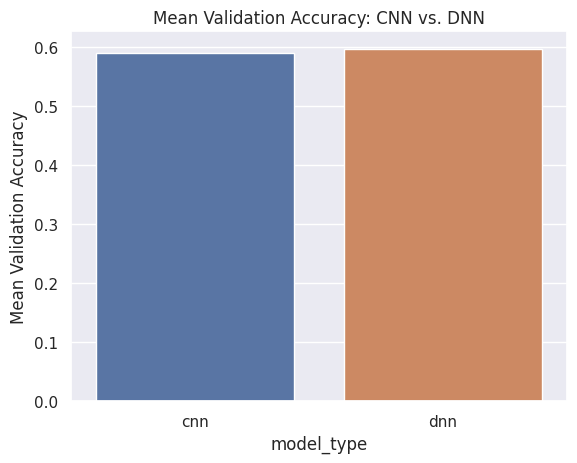

In [ ]:
mean_val_acc = all_results_df.groupby('model_type')['max_val_acc'].mean()
sns.barplot(x=mean_val_acc.index, y=mean_val_acc.values)
plt.title('Mean Validation Accuracy: CNN vs. DNN')
plt.ylabel('Mean Validation Accuracy')
plt.show()

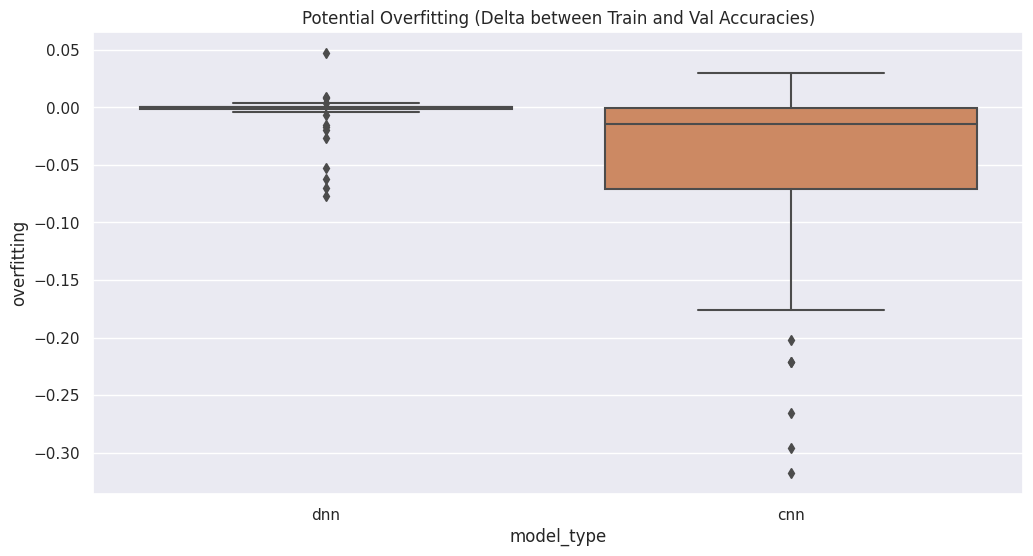

In [ ]:
all_results_df['overfitting'] = all_results_df['max_train_acc'] - all_results_df['max_val_acc']
plt.figure(figsize=(12, 6))
sns.boxplot(x='model_type', y='overfitting', data=all_results_df)
plt.title('Potential Overfitting (Delta between Train and Val Accuracies)')
plt.show()


In [ ]:
def plot_params(model_type, params):
    for param in params:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=param, y='max_val_acc', data=all_results_df[all_results_df['model_type'] == model_type])
        plt.title(f'Validation Accuracy by {param} for {model_type}')
        plt.xticks(rotation=45)
        plt.show()

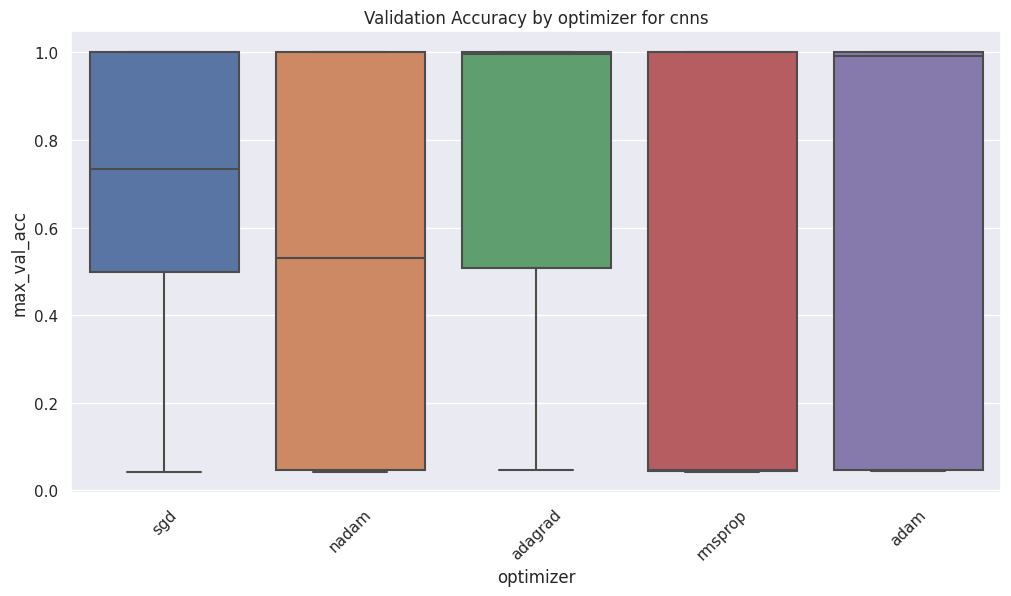

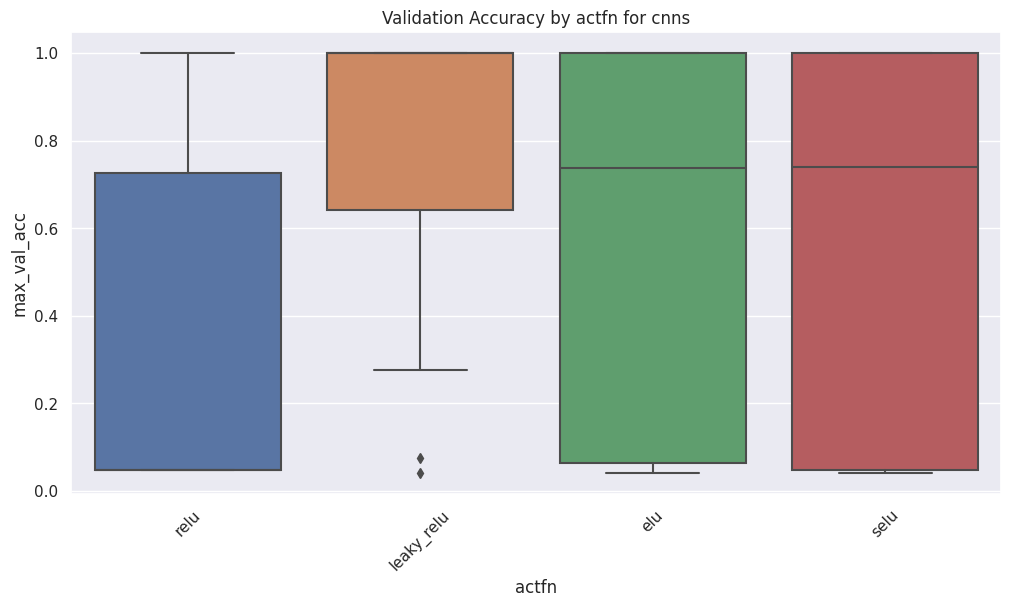

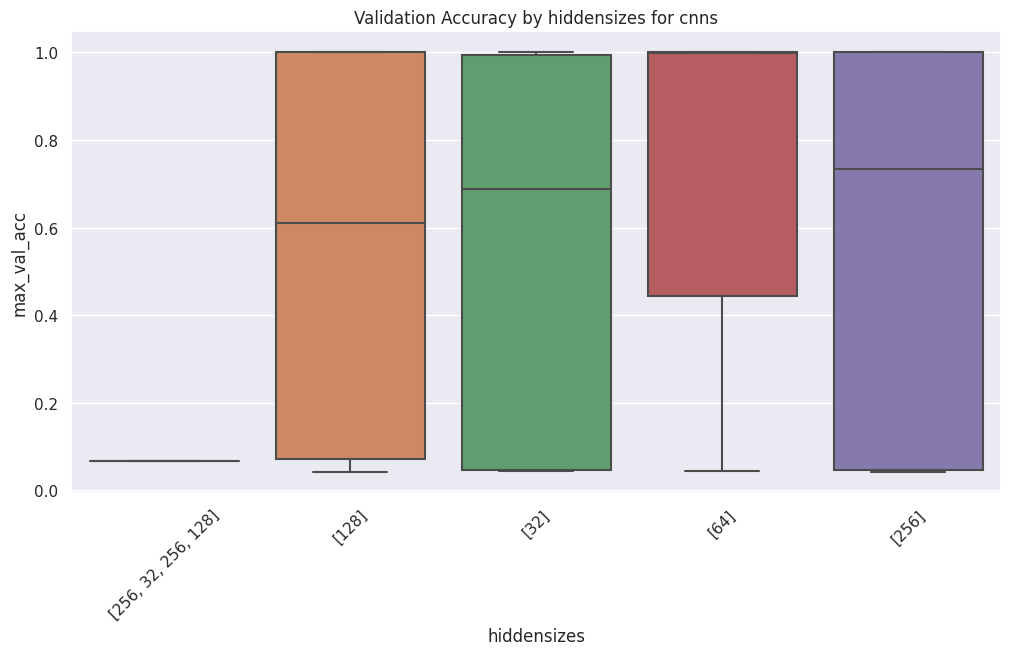

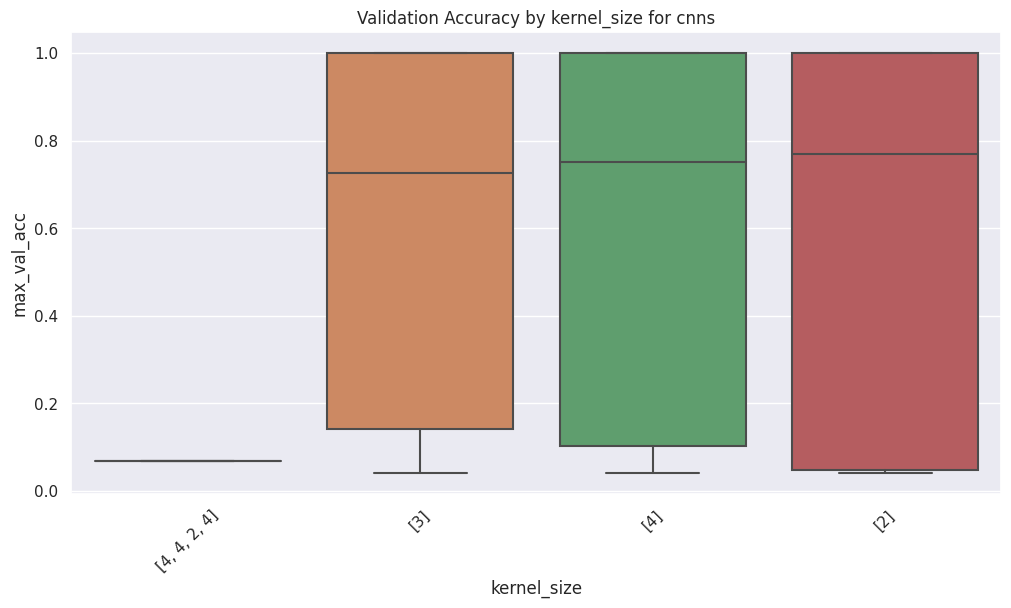

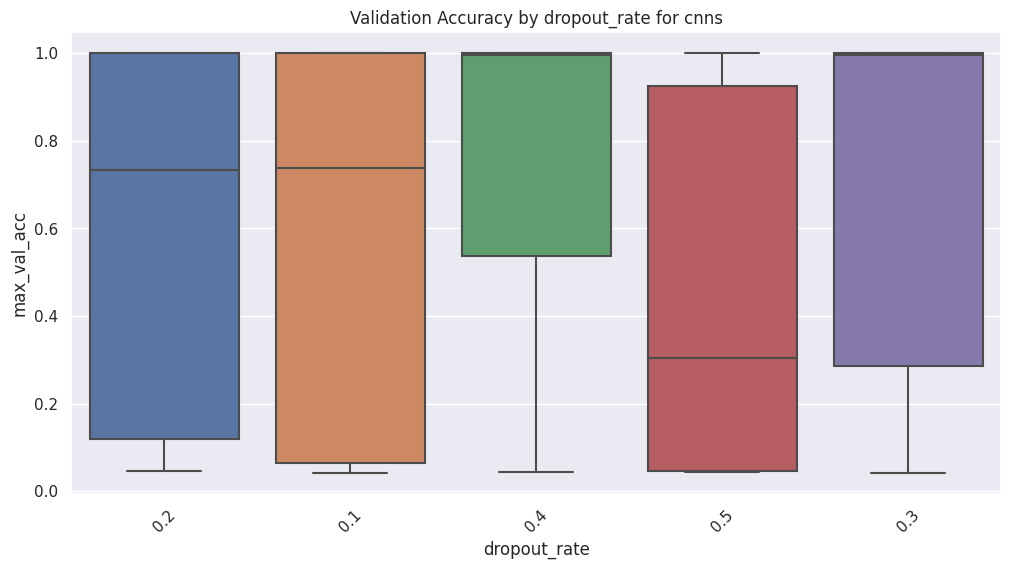

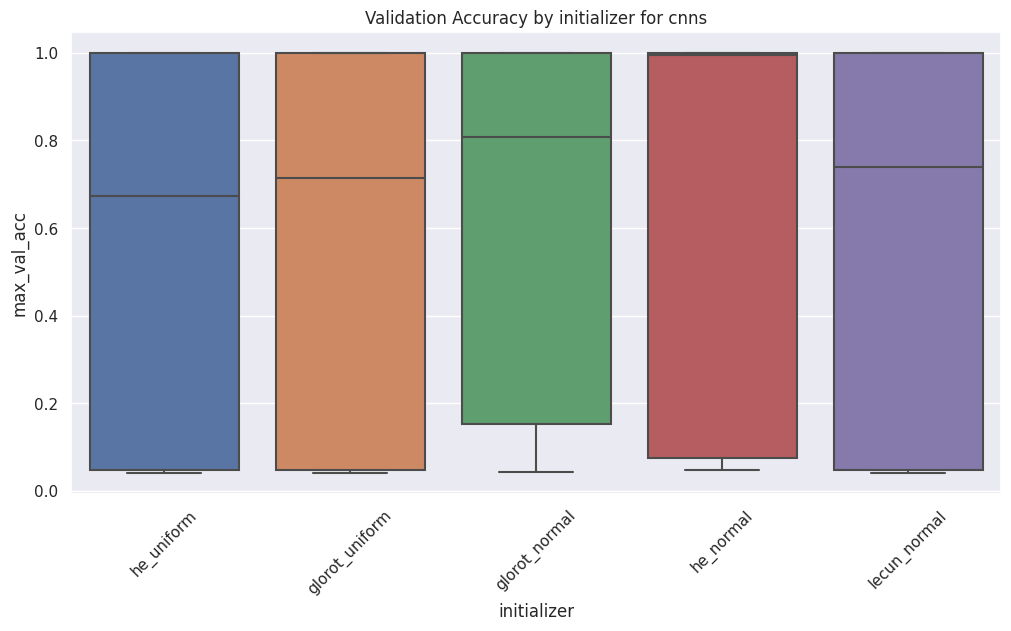

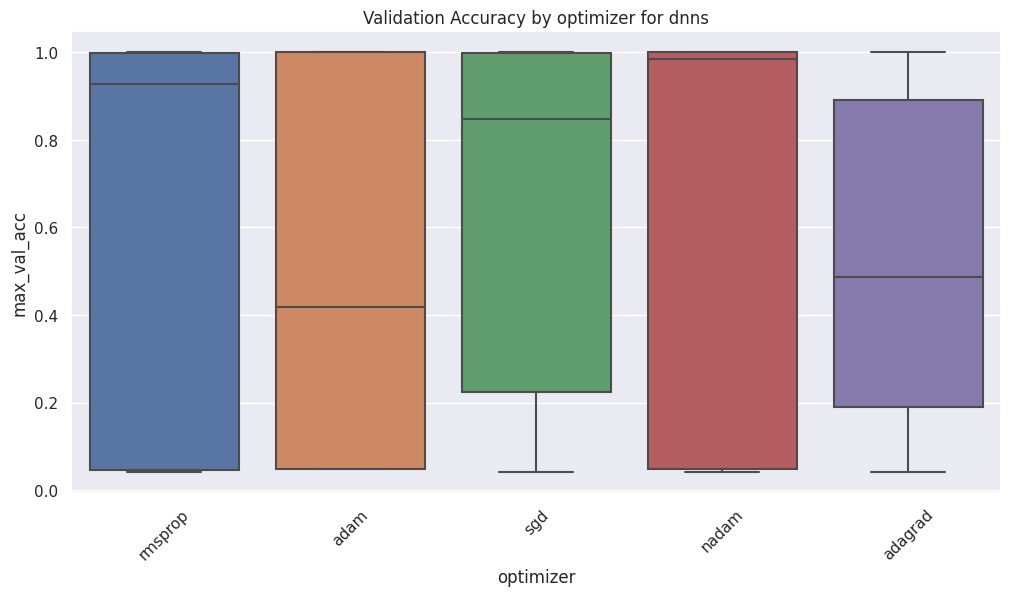

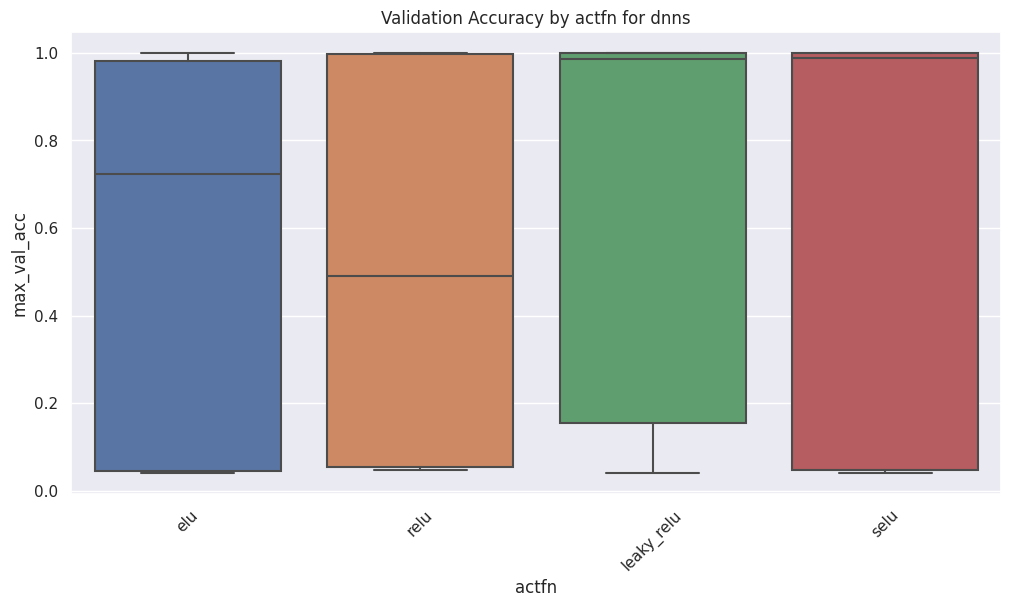

In [ ]:
all_results_df['hiddensizes'] = all_results_df['hiddensizes'].astype(str)
all_results_df['kernel_size'] = all_results_df['kernel_size'].astype(str)
all_results_df['dropout_rate'] = all_results_df['dropout_rate'].astype(str)
cnn_params = ['optimizer', 'actfn', 'hiddensizes', 'kernel_size', 'dropout_rate', 'initializer']
dnn_params = ['optimizer', 'actfn']


plot_params('cnn', cnn_params)
plot_params('dnn', dnn_params)

In [ ]:
# PRIMARY CRITERIA FOR CULLING MODELS TO < 50
# Potential Overfitting (Maximum Training Accuracy - Maximum Validation Accuracy) < 2.5%
# Maximum Validation Accuracy > 96%
# Precision Score > 96%
# Recall Score > 96%
# F1 Score > 96%

culled_df_pass_1 = all_results_df[
    (all_results_df['overfitting'] > -0.025) &
    (all_results_df['max_val_acc'] > 0.96) &
    (all_results_df['precision'] > 0.96) &
    (all_results_df['recall'] > 0.96) &
    (all_results_df['f1_score'] > 0.96)
]

In [ ]:
culled_df_pass_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 2 to 149
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   hiddensizes            48 non-null     object 
 1   actfn                  48 non-null     object 
 2   optimizer              48 non-null     object 
 3   learningrate           48 non-null     float64
 4   n_epochs               48 non-null     int64  
 5   batch_size             48 non-null     int64  
 6   max_train_acc          48 non-null     float64
 7   max_val_acc            48 non-null     float64
 8   precision              48 non-null     float64
 9   recall                 48 non-null     float64
 10  f1_score               48 non-null     float64
 11  classification_report  48 non-null     object 
 12  confusion_matrix       48 non-null     object 
 13  history                48 non-null     object 
 14  model_type             48 non-null     object 
 15  model_p

In [ ]:
culled_df_pass_1.head()

,hiddensizes,actfn,optimizer,learningrate,n_epochs,batch_size,max_train_acc,max_val_acc,precision,recall,...,classification_report,confusion_matrix,history,model_type,model_path,initializer,pool,dropout_rate,kernel_size,overfitting
2,"[32, 64, 1024, 256]",leaky_relu,rmsprop,0.0001,50,64,0.992123,0.998543,0.998557,0.998543,...,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.7103867530822754, 2.00817465782165...",dnn,/content/drive/My Drive/Sign_Language/dnn_mode...,NaN,NaN,NaN,NaN,-0.006420
3,"[128, 128]",relu,adam,0.0001,50,64,0.996949,0.995629,0.995722,0.995629,...,"{'0': {'precision': 0.974025974025974, 'recall...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.9519031047821045, 2.28668713569641...",dnn,/content/drive/My Drive/Sign_Language/dnn_mode...,NaN,NaN,NaN,NaN,0.001320
8,"[1024, 256, 64, 128, 64]",selu,rmsprop,0.0001,50,32,1.000000,1.000000,1.000000,1.000000,...,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.054302215576172, 1.039326310157775...",dnn,/content/drive/My Drive/Sign_Language/dnn_mode...,NaN,NaN,NaN,NaN,0.000000
13,"[32, 64, 512]",relu,nadam,0.0010,50,16,0.974229,0.989984,0.990077,0.989984,...,"{'0': {'precision': 0.9868421052631579, 'recal...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.075014114379883, 1.343827009201049...",dnn,/content/drive/My Drive/Sign_Language/dnn_mode...,NaN,NaN,NaN,NaN,-0.015754
14,"[1024, 256, 512]",relu,sgd,0.0100,50,32,1.000000,1.000000,1.000000,1.000000,...,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.615006923675537, 1.688278079032898...",dnn,/content/drive/My Drive/Sign_Language/dnn_mode...,NaN,NaN,NaN,NaN,0.000000


# SECONDARY NEURAL NETWORK MODEL EXPLORATION AND SELECTION

In [ ]:
# K-FOLD CROSS-VALIDATION FUNCTION

def k_fold_validation(df, X, y, n_splits=10):
    kf = KFold(n_splits=n_splits)

    results = []

    for model_idx, row in df.iterrows():

        model_name = f"{row['model_type']}-{row['hiddensizes']}-Opt:{row['optimizer']}-ActFn:{row['actfn']}"
        print(f"---Validating {model_name}---")

        val_accuracy_list = []
        val_precision_list = []
        val_recall_list = []
        val_f1_list = []

        model_path = row['model_path']
        model = load_model(model_path)

        for i, (train_index, val_index) in enumerate(kf.split(X)):
            X_train_fold, X_val_fold = X[train_index], X[val_index]
            y_train_fold, y_val_fold = y[train_index], y[val_index]

            y_pred_val = model.predict(X_val_fold).argmax(axis=1)

            accuracy = accuracy_score(y_val_fold, y_pred_val)
            precision = precision_score(y_val_fold, y_pred_val, average='weighted')
            recall = recall_score(y_val_fold, y_pred_val, average='weighted')
            f1 = f1_score(y_val_fold, y_pred_val, average='weighted')

            val_accuracy_list.append(accuracy)
            val_precision_list.append(precision)
            val_recall_list.append(recall)
            val_f1_list.append(f1)

            print(f'---Fold {i+1} for {model_name}---')
            print(f'Val Accuracy: {accuracy}')
            print(f'Val Precision: {precision}')
            print(f'Val Recall: {recall}')
            print(f'Val F1 Score: {f1}')
            print()

        results.append({
            'model_name': model_name,
            'model_path': model_path,
            'mean_accuracy': np.mean(val_accuracy_list),
            'std_accuracy': np.std(val_accuracy_list),
            'mean_precision': np.mean(val_precision_list),
            'std_precision': np.std(val_precision_list),
            'mean_recall': np.mean(val_recall_list),
            'std_recall': np.std(val_recall_list),
            'mean_f1': np.mean(val_f1_list),
            'std_f1': np.std(val_f1_list),
            **row.to_dict()
        })

        print(f"---KFold Results for {model_name}---")
        print(f'Val Mean Accuracy: {np.mean(val_accuracy_list)}, Std: {np.std(val_accuracy_list)}')
        print(f'Val Mean Precision: {np.mean(val_precision_list)}, Std: {np.std(val_precision_list)}')
        print(f'Val Mean Recall: {np.mean(val_recall_list)}, Std: {np.std(val_recall_list)}')
        print(f'Val Mean F1 Score: {np.mean(val_f1_list)}, Std: {np.std(val_f1_list)}')
        print("\n\n")

    results_df = pd.DataFrame(results)
    return results_df


In [ ]:
results_df = k_fold_validation(culled_df_pass_1, X_train_p, y_train)

---Validating dnn-[32, 64, 1024, 256]-Opt:rmsprop-ActFn:leaky_relu---
69/69 [==============================] - 0s 1ms/step
---Fold 1 for dnn-[32, 64, 1024, 256]-Opt:rmsprop-ActFn:leaky_relu---
Val Accuracy: 0.999089667728721
Val Precision: 0.9990948995233835
Val Recall: 0.999089667728721
Val F1 Score: 0.9990895870226435

69/69 [==============================] - 0s 1ms/step
---Fold 2 for dnn-[32, 64, 1024, 256]-Opt:rmsprop-ActFn:leaky_relu---
Val Accuracy: 0.999089667728721
Val Precision: 0.9991001437747
Val Recall: 0.999089667728721
Val F1 Score: 0.9990900012351103

69/69 [==============================] - 0s 1ms/step
---Fold 3 for dnn-[32, 64, 1024, 256]-Opt:rmsprop-ActFn:leaky_relu---
Val Accuracy: 0.9986345015930814
Val Precision: 0.9986583855568768
Val Recall: 0.9986345015930814
Val F1 Score: 0.9986337903390209

69/69 [==============================] - 0s 1ms/step
---Fold 4 for dnn-[32, 64, 1024, 256]-Opt:rmsprop-ActFn:leaky_relu---
Val Accuracy: 0.9990892531876139
Val Precision: 0

In [ ]:
# SAVE K-FOLD RESULTS TO FILE

results_path = os.path.join(project_folder, 'kfold_results.csv')
results_df.to_csv(results_path, index=False)

In [ ]:
# LOAD K-FOLD RESULTS FROM FILE

results_path = os.path.join(project_folder, 'kfold_results.csv')
results_df = pd.read_csv(results_path)

In [ ]:
# SECONDARY CRITERIA FOR CULLING N MODELS TO 25
# Top 25 models ranked by Mean Validation Accuracy from the K-Fold Cross-Validation Test

top_25_df = results_df.sort_values(by='mean_accuracy', ascending=False).head(25)
results_path = os.path.join(project_folder, 'top_25_mean_acc_results.csv')
top_25_df.to_csv(results_path, index=False)

top_25_df.head(25)

,model_name,model_path,mean_accuracy,std_accuracy,mean_precision,std_precision,mean_recall,std_recall,mean_f1,std_f1,...,f1_score,classification_report,confusion_matrix,history,model_type,initializer,pool,dropout_rate,kernel_size,overfitting
24,cnn-[256]-Opt:sgd-ActFn:elu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.999818,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.8841235637664795, 1.98678743839263...",cnn,glorot_uniform,[None],0.1,[4],-0.005236
20,cnn-[128]-Opt:sgd-ActFn:leaky_relu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.000000,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.346590042114258, 0.281058788299560...",cnn,he_uniform,[None],0.1,[3],0.000000
23,cnn-[128]-Opt:adam-ActFn:leaky_relu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.000000,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.019556760787964, 0.816437482833862...",cnn,he_normal,['avg'],0.3,[3],-0.000728
25,cnn-[64]-Opt:rmsprop-ActFn:leaky_relu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.000000,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.26719331741333, 0.6466073393821716...",cnn,he_normal,['avg'],0.5,[4],-0.011519
27,cnn-[128]-Opt:sgd-ActFn:leaky_relu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.000000,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [1.3190058469772339, 0.18936221301555...",cnn,he_normal,['avg'],0.3,[4],-0.000137
30,cnn-[128]-Opt:rmsprop-ActFn:leaky_relu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.000000,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [1.4056000709533691, 0.09674336761236...",cnn,he_uniform,['avg'],0.2,[3],0.000000
31,cnn-[256]-Opt:adagrad-ActFn:relu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.000000,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [1.0522993803024292, 0.15954338014125...",cnn,he_uniform,['max'],0.4,[4],-0.000455
32,cnn-[64]-Opt:nadam-ActFn:selu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.000000,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.3555476665496826, 1.39066028594970...",cnn,lecun_normal,[None],0.1,[4],-0.001594
34,cnn-[64]-Opt:adagrad-ActFn:leaky_relu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.000000,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [18.35395050048828, 2.579237699508667...",cnn,he_uniform,[None],0.5,[3],-0.011064
35,cnn-[128]-Opt:adagrad-ActFn:selu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.000000,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.857076644897461, 1.898480534553527...",cnn,lecun_normal,[None],0.1,[4],-0.009971


In [ ]:
# TERTIARY CRITERIA FOR CULLING N MODELS TO 10
# Top lowest Standard Deviation of the F1 Score (prioritizing performance stability across folds)

top_10_std_f1 = top_25_df.sort_values(by='std_f1', ascending=True).head(10)
results_path = os.path.join(project_folder, 'top_10_std_f1_results.csv')
top_10_std_f1.to_csv(results_path, index=False)
top_10_std_f1.head(10)

,model_name,model_path,mean_accuracy,std_accuracy,mean_precision,std_precision,mean_recall,std_recall,mean_f1,std_f1,...,f1_score,classification_report,confusion_matrix,history,model_type,initializer,pool,dropout_rate,kernel_size,overfitting
24,cnn-[256]-Opt:sgd-ActFn:elu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.999818,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.8841235637664795, 1.98678743839263...",cnn,glorot_uniform,[None],0.1,[4],-0.005236
11,"dnn-[512, 512, 32, 256, 512]-Opt:nadam-ActFn:l...",/content/drive/My Drive/Sign_Language/dnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.000000,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.6901843547821045, 1.56711447238922...",dnn,NaN,NaN,NaN,NaN,0.000000
12,"dnn-[1024, 128]-Opt:nadam-ActFn:elu",/content/drive/My Drive/Sign_Language/dnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.000000,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.1759965419769287, 1.31838488578796...",dnn,NaN,NaN,NaN,NaN,0.000000
47,cnn-[256]-Opt:rmsprop-ActFn:leaky_relu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.000000,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.6818156242370605, 1.47004389762878...",cnn,he_normal,['avg'],0.5,[2],-0.017848
22,cnn-[64]-Opt:adam-ActFn:elu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.000000,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.7024993896484375, 1.89173424243927...",cnn,glorot_normal,[None],0.5,[4],-0.018804
45,cnn-[256]-Opt:sgd-ActFn:relu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.000000,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.5935251712799072, 1.71053767204284...",cnn,he_uniform,['avg'],0.3,[2],-0.014889
44,cnn-[256]-Opt:rmsprop-ActFn:elu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.000000,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [1.3639228343963623, 0.64362925291061...",cnn,glorot_normal,['avg'],0.4,[2],-0.000911
43,cnn-[128]-Opt:nadam-ActFn:elu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.000000,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.0928030014038086, 1.07367467880249...",cnn,glorot_uniform,[None],0.5,[3],-0.000728
42,cnn-[256]-Opt:rmsprop-ActFn:elu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.000000,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [1.951466679573059, 0.844781100749969...",cnn,glorot_normal,['max'],0.1,[4],0.000000
41,cnn-[64]-Opt:sgd-ActFn:leaky_relu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.000000,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [3.3023619651794434, 2.06898808479309...",cnn,he_uniform,[None],0.2,[4],-0.008241


In [ ]:
# FUNCTION TO PLOT NEURAL NETWORK MODEL ARCHITECTURE

def plot_model_architecture(model, title, rank):
    file_path = f"temp_plot_{rank}.png"
    plot_model(model, to_file=file_path, show_shapes=True, show_layer_names=True, dpi=70, rankdir="LR")

    img = Image.open(file_path)
    img_with_title = Image.new('RGB', (img.width, img.height + 30), color='white')
    img_with_title.paste(img, (0,30))

    from PIL import ImageDraw, ImageFont
    d = ImageDraw.Draw(img_with_title)
    fnt = ImageFont.load_default()
    d.text((10,5), f"Rank {rank}: {title}", font=fnt, fill="black")

    img_with_title.save(file_path)

    display.display(display.Image(filename=file_path))


Loading model 1...


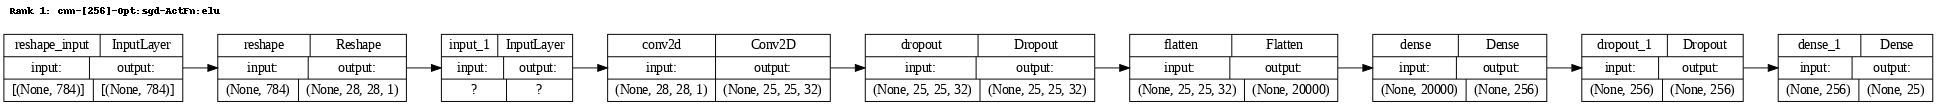

----------------------------------------------------------------------------------------------------
Loading model 2...


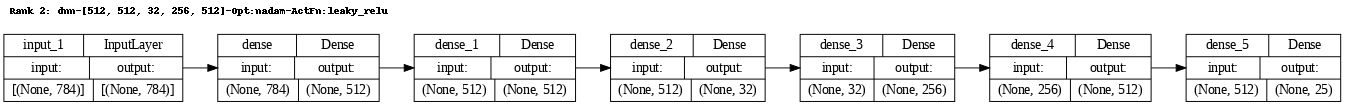

----------------------------------------------------------------------------------------------------
Loading model 3...


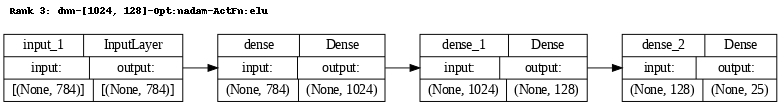

----------------------------------------------------------------------------------------------------
Loading model 4...


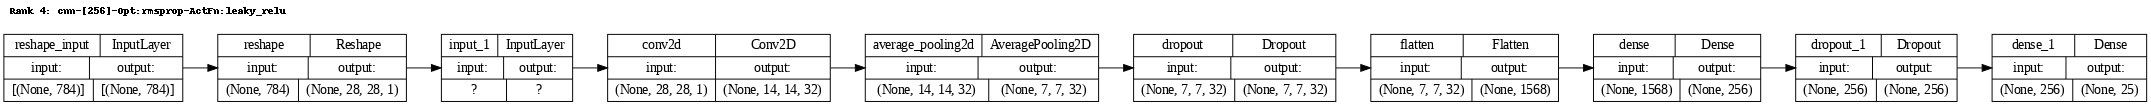

----------------------------------------------------------------------------------------------------
Loading model 5...


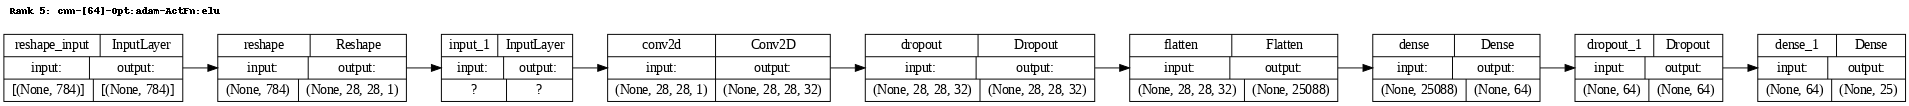

----------------------------------------------------------------------------------------------------
Loading model 6...


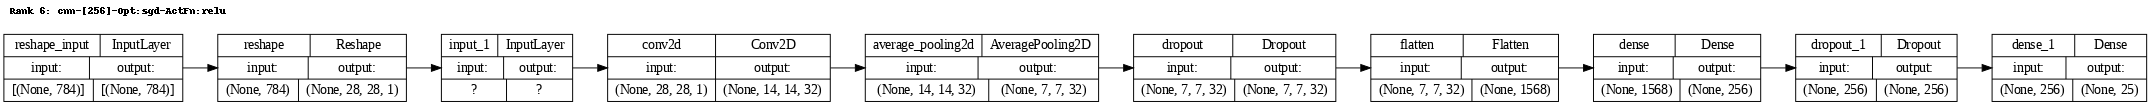

----------------------------------------------------------------------------------------------------
Loading model 7...


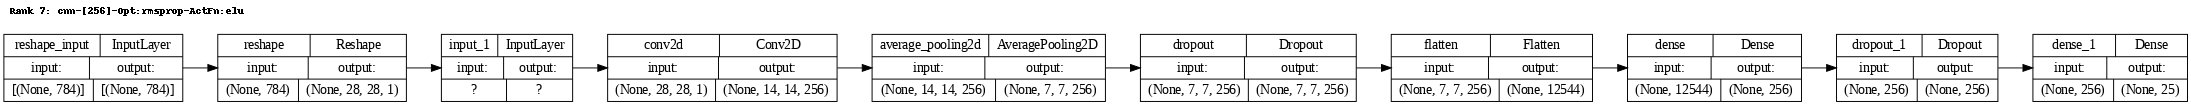

----------------------------------------------------------------------------------------------------
Loading model 8...


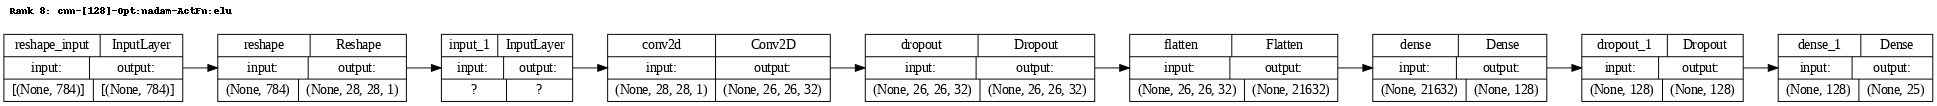

----------------------------------------------------------------------------------------------------
Loading model 9...


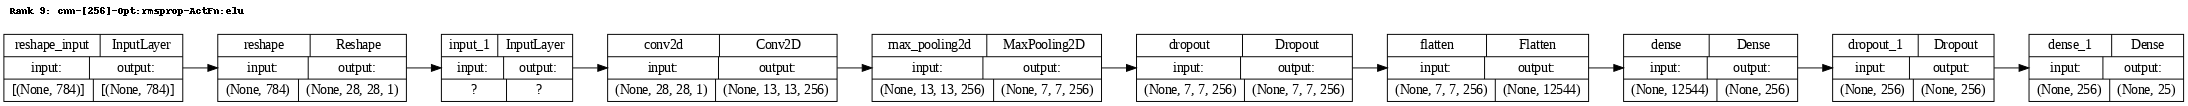

----------------------------------------------------------------------------------------------------
Loading model 10...


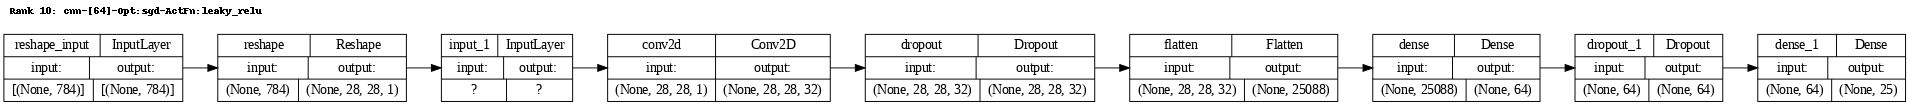

----------------------------------------------------------------------------------------------------


In [ ]:
for index, (idx, row) in enumerate(top_10_std_f1.iterrows()):
    print(f"Loading model {index+1}...")
    model = load_model(row['model_path'])
    plot_model_architecture(model, row['model_name'], index+1)
    print("-"*100)

In [ ]:
top_10_std_f1 = top_10_std_f1.reset_index(drop=True)

In [ ]:
# FUNCTION TO PLOT LEARNING CURVES (TRAINING AND VALIDATION ACCURACY AND LOSS)

def plot_learning_curves(history, title=""):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title(f'Accuracy - {title}', fontsize=8)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title(f'Loss - {title}', fontsize=8)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


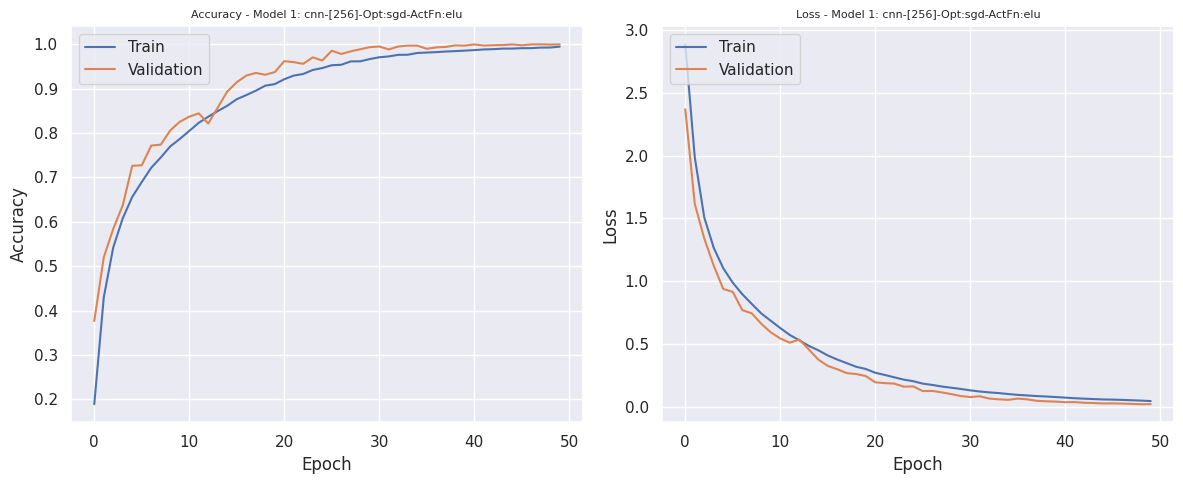

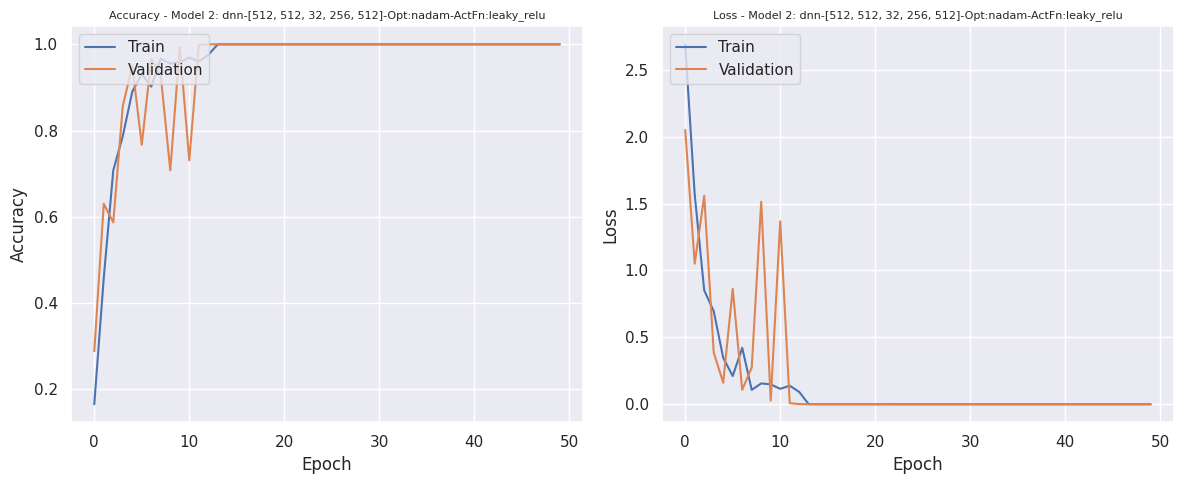

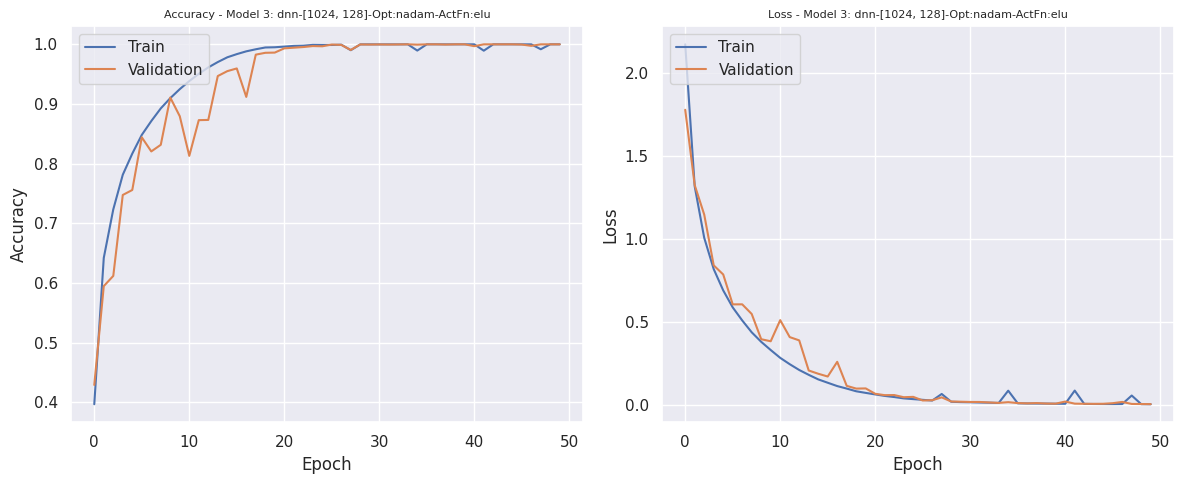

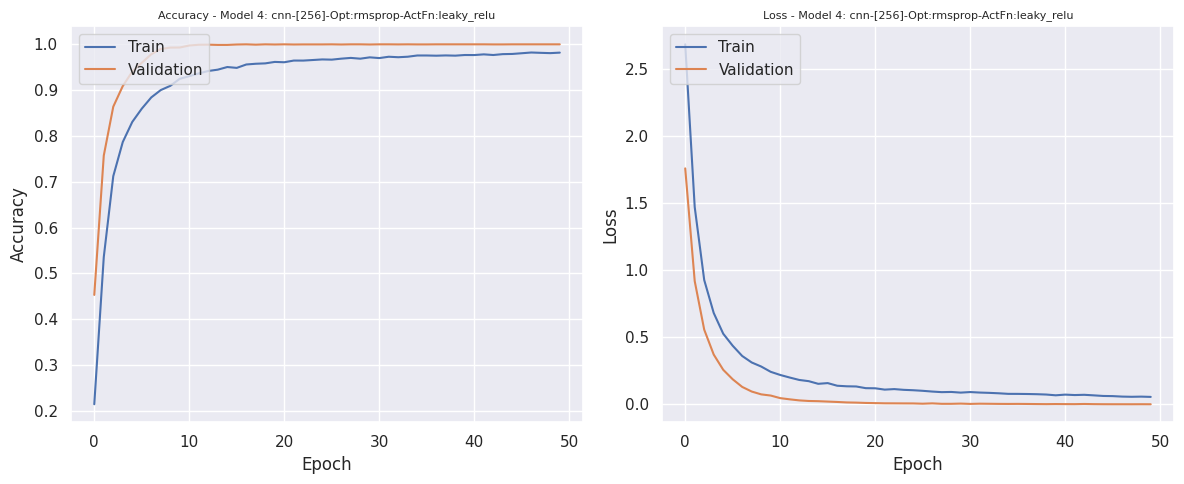

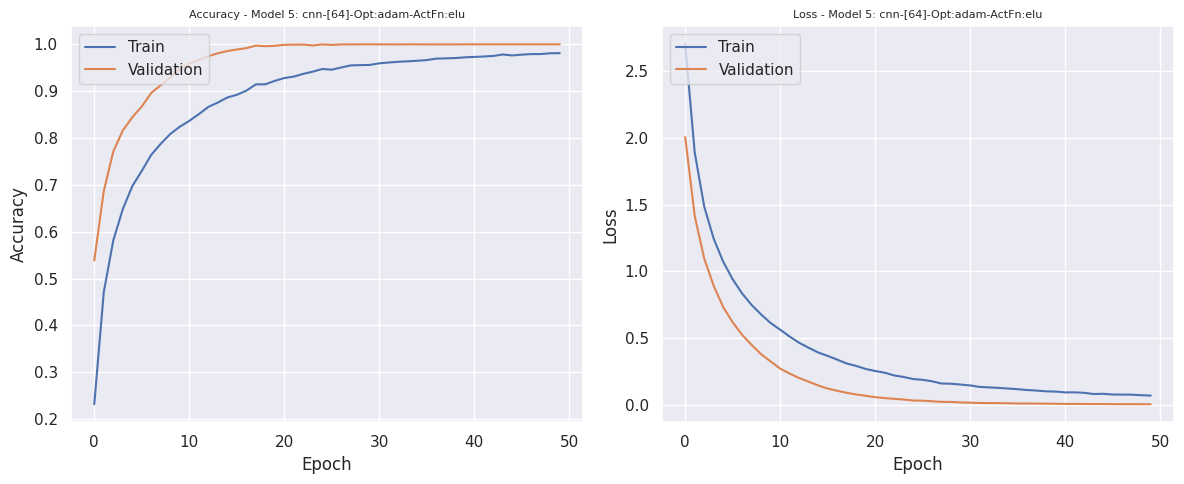

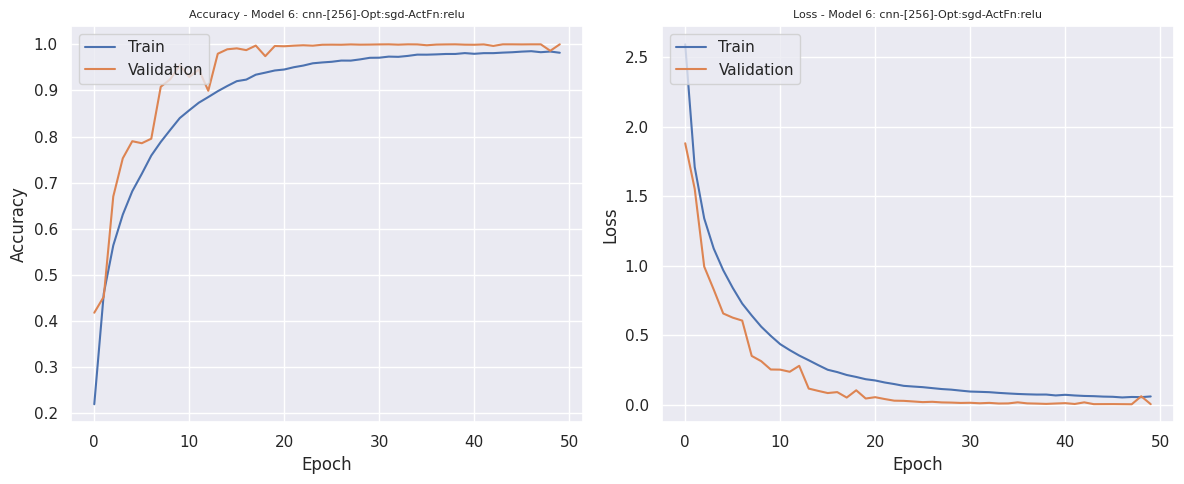

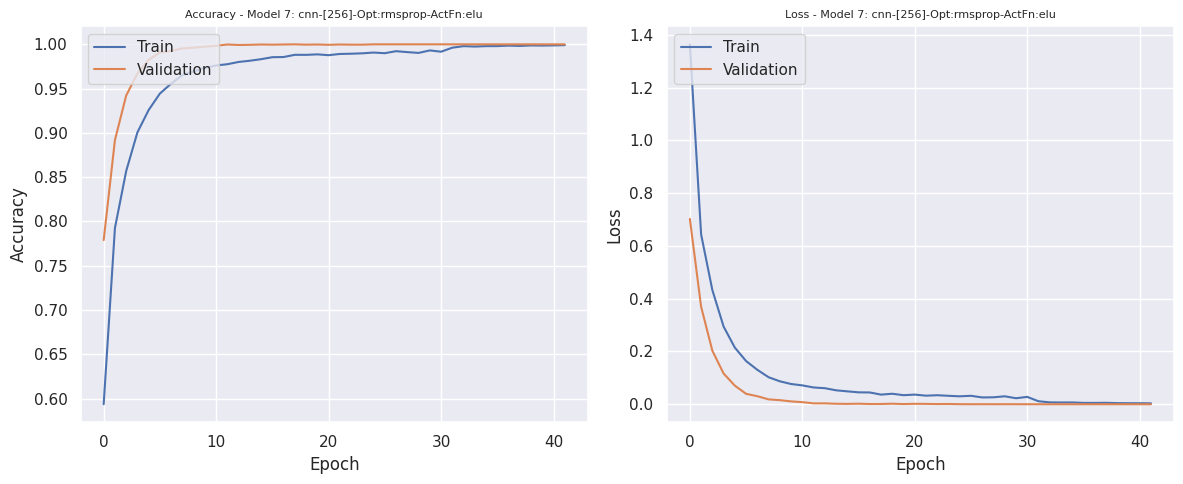

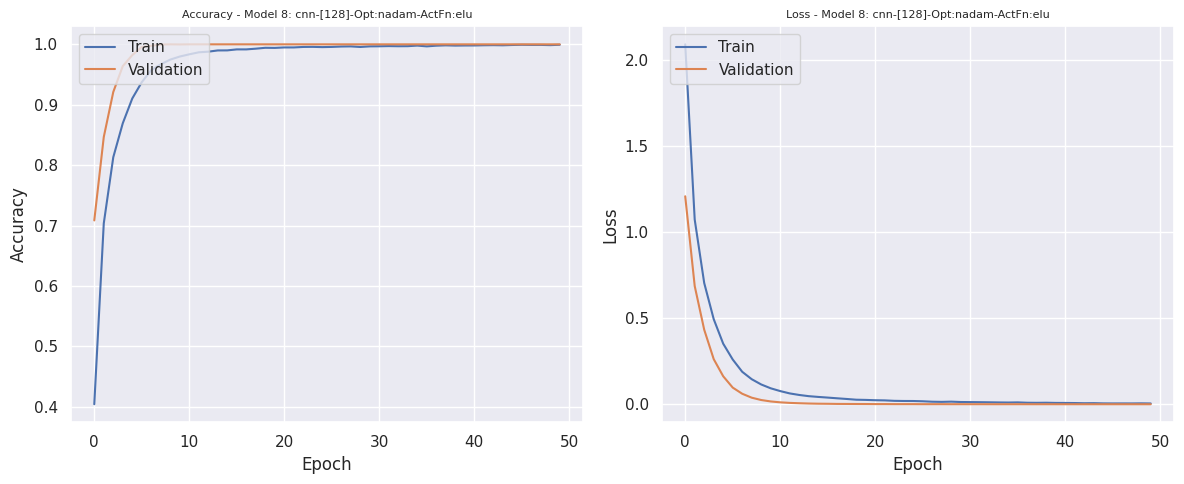

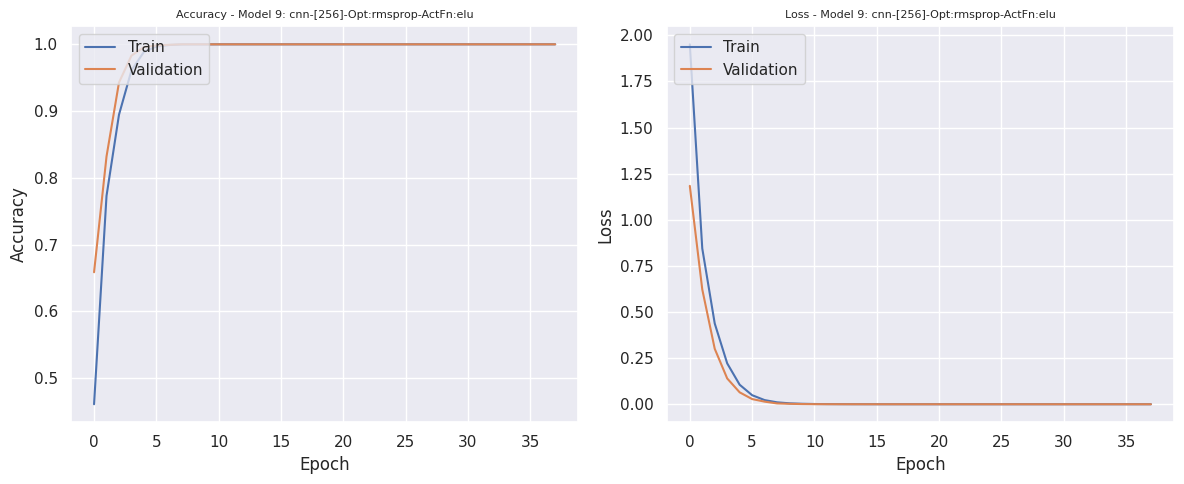

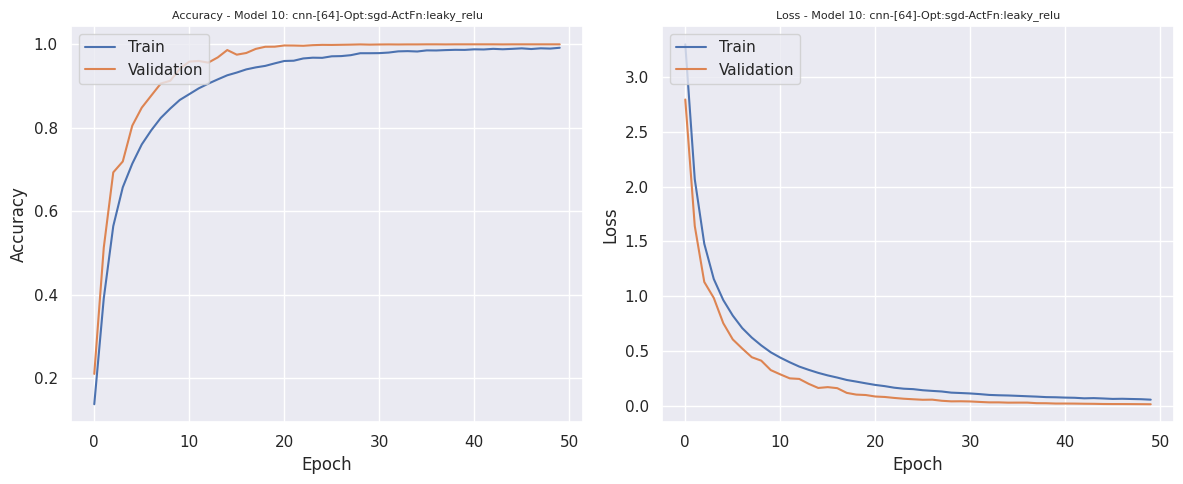

In [ ]:
for index, row in top_10_std_f1.iterrows():
    history = ast.literal_eval(row["history"])
    model_info = f"Model {index + 1}: {row['model_name']}"
    plot_learning_curves(history, title=model_info)

In [ ]:
# FUNCTION TO PLOT CONFUSION MATRICES

def plot_confusion_matrix(ax, cm, labels):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

def process_cm(top_10_df, X_val, y_val, mapping):
    num_models = top_10_df.shape[0]
    fig, axes = plt.subplots(nrows=int(num_models/2), ncols=2, figsize=(14, 7 * int(num_models/2)))

    for idx, (row_index, row) in enumerate(top_10_df.iterrows()):
        ax = axes.ravel()[idx]
        print(f"Processing model: {row['model_name']}...")

        model = load_model(row['model_path'])

        y_pred = model.predict(X_val).argmax(axis=1)

        cm_labels = sorted(list(mapping.keys()))
        plot_labels = [mapping[val] for val in cm_labels]

        cm = confusion_matrix(y_val, y_pred, labels=cm_labels)
        plot_confusion_matrix(ax, cm, plot_labels)

        ax.set_title(f"Model {idx+1}: {row['model_name']}")

        print("-"*100)

    plt.tight_layout()
    plt.show()



Processing model: cnn-[256]-Opt:sgd-ActFn:elu...
172/172 [==============================] - 0s 1ms/step
----------------------------------------------------------------------------------------------------
Processing model: dnn-[512, 512, 32, 256, 512]-Opt:nadam-ActFn:leaky_relu...
172/172 [==============================] - 0s 1ms/step
----------------------------------------------------------------------------------------------------
Processing model: dnn-[1024, 128]-Opt:nadam-ActFn:elu...
172/172 [==============================] - 0s 1ms/step
----------------------------------------------------------------------------------------------------
Processing model: cnn-[256]-Opt:rmsprop-ActFn:leaky_relu...
172/172 [==============================] - 1s 1ms/step
----------------------------------------------------------------------------------------------------
Processing model: cnn-[64]-Opt:adam-ActFn:elu...
172/172 [==============================] - 0s 1ms/step
-----------------------------

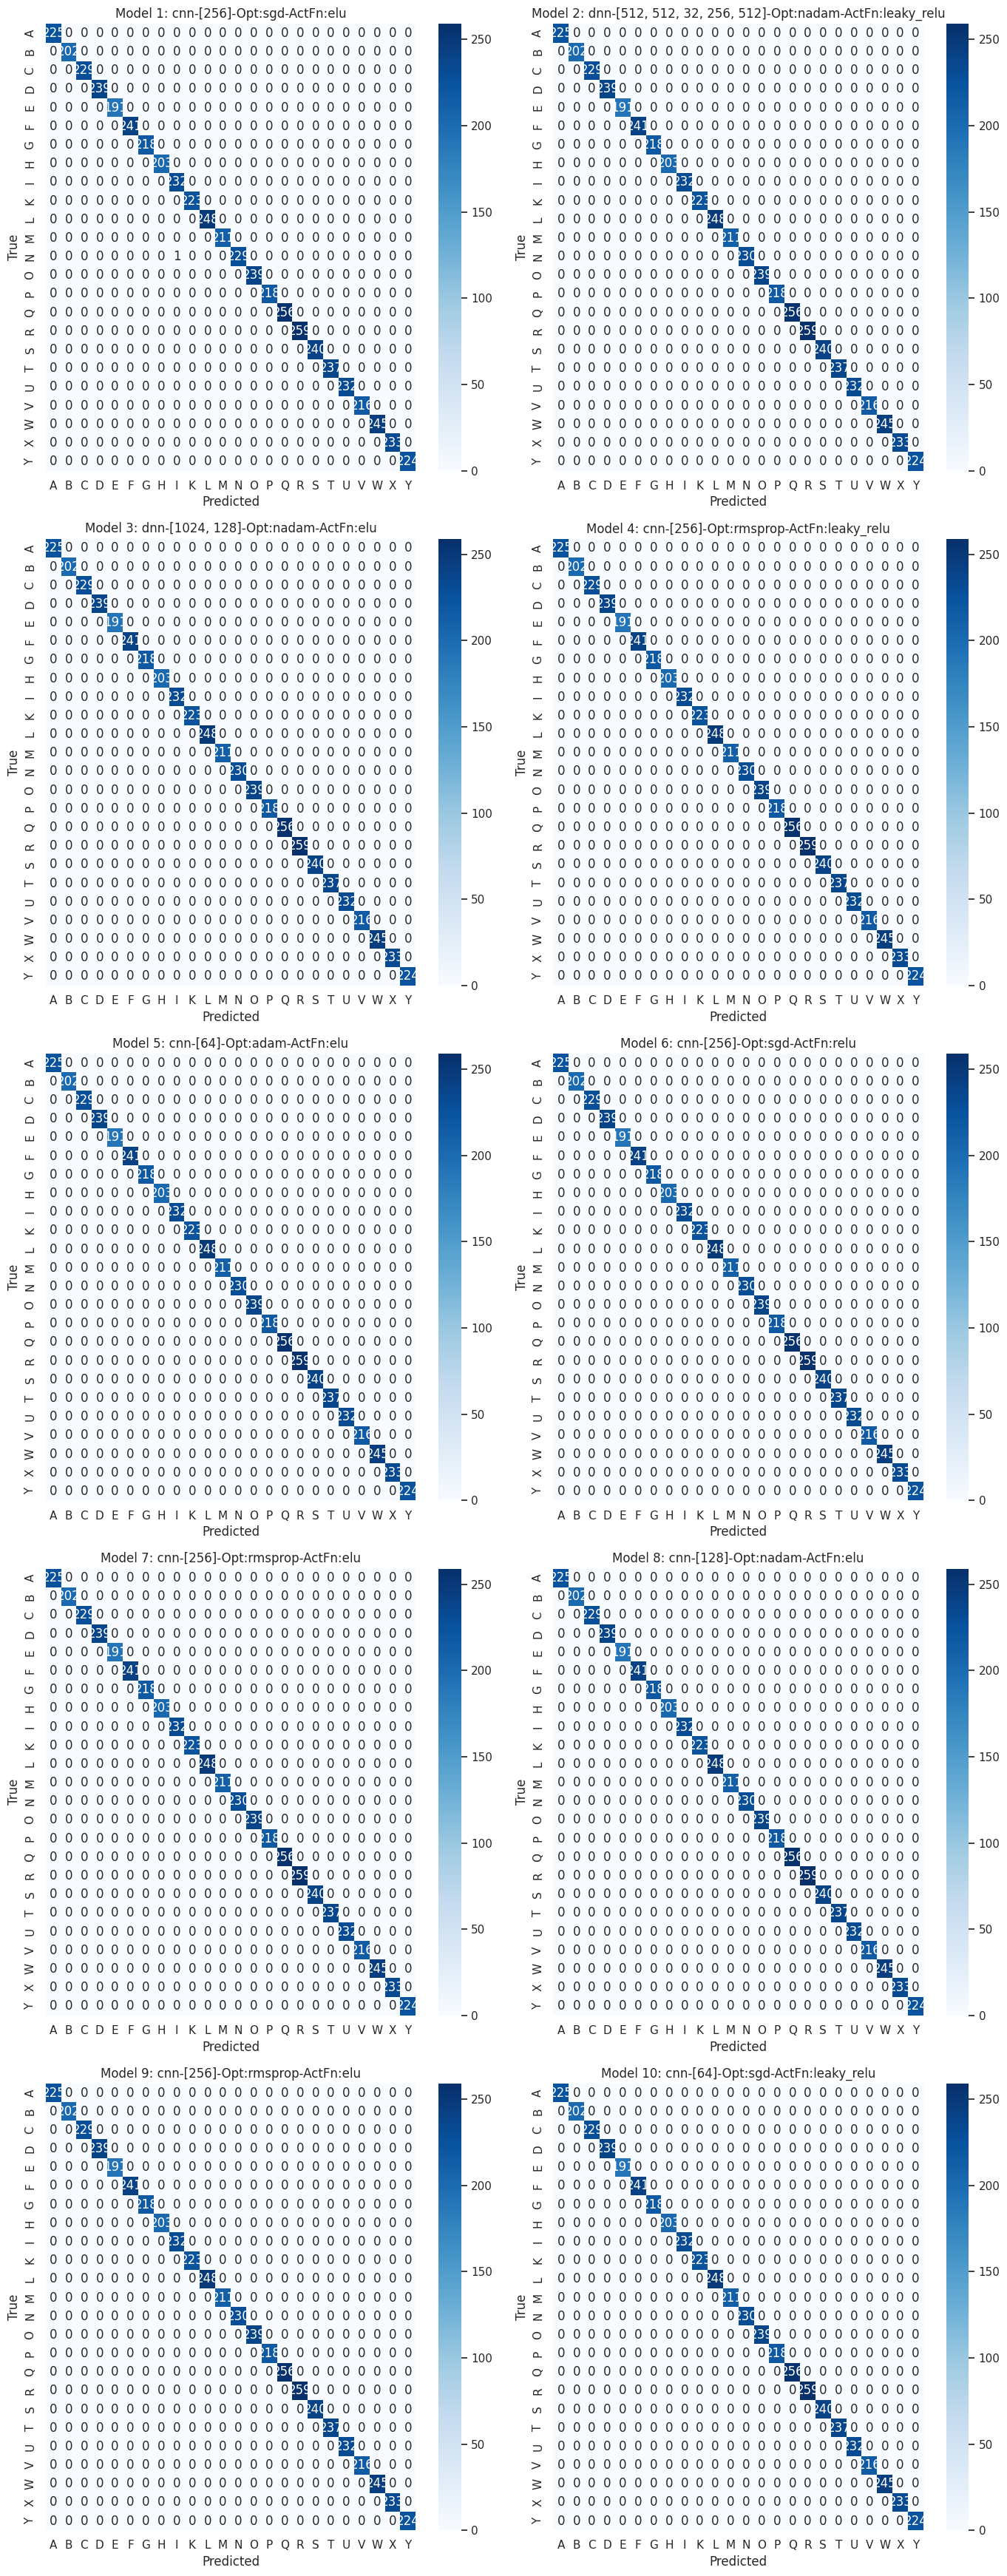

In [ ]:
process_cm(top_10_std_f1, X_valid_p, y_valid, mapping)

In [ ]:
# QUATERNARY CRITERIA FOR CULLING N MODELS
# Remove models with the most unstable learning curves
# Confusion matrices are identical for all models

n_model_to_idx = {i+1: i for i, _ in top_10_std_f1.iterrows()}

def drop_models_by_numbers(df, model_numbers_to_drop, mapping):
    idx_to_drop = [mapping[number] for number in model_numbers_to_drop]
    return df.drop(idx_to_drop)

k_model_to_drop = [2, 3, 6]
top_n_models = drop_models_by_numbers(top_10_std_f1, k_model_to_drop, n_model_to_idx)
top_n_models.head(7)

,model_name,model_path,mean_accuracy,std_accuracy,mean_precision,std_precision,mean_recall,std_recall,mean_f1,std_f1,...,f1_score,classification_report,confusion_matrix,history,model_type,initializer,pool,dropout_rate,kernel_size,overfitting
0,cnn-[256]-Opt:sgd-ActFn:elu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.999818,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.8841235637664795, 1.98678743839263...",cnn,glorot_uniform,[None],0.1,[4],-0.005236
3,cnn-[256]-Opt:rmsprop-ActFn:leaky_relu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.000000,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.6818156242370605, 1.47004389762878...",cnn,he_normal,['avg'],0.5,[2],-0.017848
4,cnn-[64]-Opt:adam-ActFn:elu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.000000,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.7024993896484375, 1.89173424243927...",cnn,glorot_normal,[None],0.5,[4],-0.018804
6,cnn-[256]-Opt:rmsprop-ActFn:elu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.000000,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [1.3639228343963623, 0.64362925291061...",cnn,glorot_normal,['avg'],0.4,[2],-0.000911
7,cnn-[128]-Opt:nadam-ActFn:elu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.000000,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.0928030014038086, 1.07367467880249...",cnn,glorot_uniform,[None],0.5,[3],-0.000728
8,cnn-[256]-Opt:rmsprop-ActFn:elu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.000000,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [1.951466679573059, 0.844781100749969...",cnn,glorot_normal,['max'],0.1,[4],0.000000
9,cnn-[64]-Opt:sgd-ActFn:leaky_relu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.000000,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [3.3023619651794434, 2.06898808479309...",cnn,he_uniform,[None],0.2,[4],-0.008241


In [ ]:
# FUNCTION TO COMPUTE P VALUES

def generate_p_values(culled_df, X_valid_p, y_valid):

    y_valid_preds = []
    model_numbers = [index + 1 for index in culled_df.index]

    for index, row in culled_df.iterrows():
        model = load_model(row['model_path'])
        predictions = model.predict(X_valid_p)
        y_pred = np.argmax(predictions, axis=1)
        y_valid_preds.append(y_pred)

    pvals = []
    ntests = 0
    num_models = len(y_valid_preds)

    for n1 in range(num_models):
        for n2 in range(n1 + 1, num_models):
            p_value = permutation_test(
                y_valid_preds[n1],
                y_valid_preds[n2],
                paired=True,
                func=lambda x, y: np.abs(f1_score(y_valid, x, average='weighted') -
                                         f1_score(y_valid, y, average='weighted')),
                method="approximate",
                seed=0,
                num_rounds=1000
            )

            ntests += 1
            pvals.append(p_value)
            print(f"P value comparing models {model_numbers[n1]} and {model_numbers[n2]}: {p_value:.3f}")

    threshold = 0.05 / ntests
    print(f"Threshold for significance: {threshold:.4f}")

    return pvals

In [ ]:
p_values = generate_p_values(top_n_models, X_valid_p, y_valid)

172/172 [==============================] - 0s 1ms/step
P value comparing models 1 and 4: 1.000
P value comparing models 1 and 5: 1.000
P value comparing models 1 and 7: 1.000
P value comparing models 1 and 8: 1.000
P value comparing models 1 and 9: 1.000
P value comparing models 1 and 10: 1.000
P value comparing models 4 and 5: 1.000
P value comparing models 4 and 7: 1.000
P value comparing models 4 and 8: 1.000
P value comparing models 4 and 9: 1.000
P value comparing models 4 and 10: 1.000
P value comparing models 5 and 7: 1.000
P value comparing models 5 and 8: 1.000
P value comparing models 5 and 9: 1.000
P value comparing models 5 and 10: 1.000
P value comparing models 7 and 8: 1.000
P value comparing models 7 and 9: 1.000
P value comparing models 7 and 10: 1.000
P value comparing models 8 and 9: 1.000
P value comparing models 8 and 10: 1.000
P value comparing models 9 and 10: 1.000
Threshold for significance: 0.0024


# FINAL MODEL SELECTION AND TESTING

In [ ]:
# FINAL BEST MODEL SELECTION CRITERIA
# ENTIA NON SUNT MULTIPLICANDA PRAETER NECESSITATEM

# Given there is no meaningfully statistical difference in performance between the remaining 7 models,
# it stands to reason that the least complex of the cohort will be chosen.

def get_model_params(model_path):
    model = load_model(model_path)
    return model.count_params()

complexity = top_n_models['model_path'].apply(get_model_params)

top_n_models['complexity'] = complexity

In [ ]:
final_2_models = top_n_models.sort_values(by='complexity', ascending=True).head(2)
final_2_models.head()

,model_name,model_path,mean_accuracy,std_accuracy,mean_precision,std_precision,mean_recall,std_recall,mean_f1,std_f1,...,classification_report,confusion_matrix,history,model_type,initializer,pool,dropout_rate,kernel_size,overfitting,complexity
3,cnn-[256]-Opt:rmsprop-ActFn:leaky_relu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.6818156242370605, 1.47004389762878...",cnn,he_normal,['avg'],0.5,[2],-0.017848,408249
4,cnn-[64]-Opt:adam-ActFn:elu,/content/drive/My Drive/Sign_Language/cnn_mode...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...","[[225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'loss': [2.7024993896484375, 1.89173424243927...",cnn,glorot_normal,[None],0.5,[4],-0.018804,1607865


In [ ]:
# DISPLAY NEURAL NETWORK ARCHITECTURE AND TOTAL PARAMETERS FOR BEST AND SECOND BEST MODELS

best_model_path = sorted_models.iloc[0]['model_path']
best_model_idx = sorted_models.index[0]
second_best_model_path = sorted_models.iloc[1]['model_path']
second_best_model_idx = sorted_models.index[1]

best_model = load_model(best_model_path)
print(f"BEST MODEL ({best_model_idx}):")
print("="*50)
best_model.summary()

print("\n")

second_best_model = load_model(second_best_model_path)
print(f"SECOND BEST MODEL ({second_best_model_idx}):")
print("="*50)
second_best_model.summary()

BEST MODEL (3):
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        160       
                                                                 
 average_pooling2d (AverageP  (None, 7, 7, 32)         0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 7, 7, 32)          0         
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                        

In [ ]:
# DOWNLOAD THE SIGN LANGUAGE TESTING DATA SET

output_path_test = os.path.join(project_folder, 'sign_mnist_test.csv')
file_id = ""
url = f"https://drive.google.com/uc?export=download&id={file_id}"
gdown.download(url, output_path_test, quiet=False)

In [ ]:
test_df = pd.read_csv(output_path_test)

In [ ]:
X_test = test_df.drop("label", axis=1).values
y_test = test_df["label"].values

In [ ]:
# SCALE THE TEST DATA

X_test_p = pipeline.transform(X_test)

In [ ]:
# VERIFY SCALING

print(f"min post scaling: {X_test_p.min()}")
print(f"max post scaling: {X_test_p.max()}")

min post scaling: -0.10869565217391304
max post scaling: 1.0000000000000002


In [ ]:
# VERIFY INPUT SHAPE

unique_shapes = set([img.shape for img in X_test_p])
print(unique_shapes)

{(784,)}


In [ ]:
# BEST MODEL EVALUATION ON THE TEST DATA

best_model_path = final_2_models.iloc[0]['model_path']
best_model = load_model(best_model_path)

y_pred_best = best_model.predict(X_test_p)

y_pred_best_class = np.argmax(y_pred_best, axis=1)

225/225 [==============================] - 0s 1ms/step


In [ ]:
# BEST MODEL TEST METRICS

accuracy_best = accuracy_score(y_test, y_pred_best_class)
precision_best = precision_score(y_test, y_pred_best_class, average='weighted')
recall_best = recall_score(y_test, y_pred_best_class, average='weighted')
f1_best = f1_score(y_test, y_pred_best_class, average='weighted')

print(f"Best Model Test Metrics: \n\nAccuracy: {accuracy_best}\nPrecision: {precision_best}\nRecall: {recall_best}\nF1 Score: {f1_best}\n")

Best Model Test Metrics: 

Accuracy: 0.8588957055214724
Precision: 0.8672846488447822
Recall: 0.8588957055214724
F1 Score: 0.8596462400209928



In [ ]:
# ACCURACY OF EACH INDIVIDUAL LETTER

y_test_letters = [mapping[label] for label in y_test]

for letter, label in mapping.items():
    correct_predictions = sum([1 for true, pred in zip(y_test_letters, y_pred_best_labels) if true == label and pred == label])
    total_instances = y_test_letters.count(label)

    accuracy = correct_predictions / total_instances
    print(f"Accuracy for letter {label}: {accuracy:.2%}")


Accuracy for letter A: 100.00%
Accuracy for letter B: 90.51%
Accuracy for letter C: 97.42%
Accuracy for letter D: 93.06%
Accuracy for letter E: 95.78%
Accuracy for letter F: 99.60%
Accuracy for letter G: 82.76%
Accuracy for letter H: 93.35%
Accuracy for letter I: 94.10%
Accuracy for letter K: 77.95%
Accuracy for letter L: 100.00%
Accuracy for letter M: 76.90%
Accuracy for letter N: 63.92%
Accuracy for letter O: 76.42%
Accuracy for letter P: 91.64%
Accuracy for letter Q: 100.00%
Accuracy for letter R: 64.58%
Accuracy for letter S: 82.52%
Accuracy for letter T: 72.58%
Accuracy for letter U: 62.78%
Accuracy for letter V: 71.68%
Accuracy for letter W: 80.10%
Accuracy for letter X: 91.39%
Accuracy for letter Y: 88.25%


In [ ]:
# LETTER WITH THE LOWEST ACCURACY

accuracies = {}

for letter, label in mapping.items():
    correct_predictions = sum([1 for true, pred in zip(y_test_letters, y_pred_best_labels) if true == label and pred == label])
    total_instances = y_test_letters.count(label)

    if total_instances == 0:
        continue

    accuracies[label] = correct_predictions / total_instances

lowest_accuracy_letter = min(accuracies, key=accuracies.get)
print(f"Letter with the lowest accuracy: {lowest_accuracy_letter} with accuracy of {accuracies[lowest_accuracy_letter]:.2%}")

Letter with the lowest accuracy: U with accuracy of 62.78%


In [ ]:
# THE MOST COMMON ERROR
# (of one letter being incorrectly labelled as another)

cm = confusion_matrix(y_test_letters, y_pred_best_labels, labels=list(mapping.values()))

np.fill_diagonal(cm, 0)
row, col = np.unravel_index(cm.argmax(), cm.shape)

true_label = list(mapping.values())[row]
misclassified_as = list(mapping.values())[col]

print(f"The most common error is classifying {true_label} as {misclassified_as}.")

The most common error is classifying U as R.


# RECOMMENDATIONS AND CONCLUDING REMARKS

---

The best model achieves an overall accuracy of 85.89%, with a precision of 86.73%, a recall of 85.89%, and an F1 Score of 85.96%.

*   10 out of the 24 letters exceed the 90% accuracy benchmark
*   The letter 'U' had the lowest accuracy, at 62.78%
*   The most frequent misclassification was the letter U being classified as R

While the model performs reasonably well with an overall accuracy close to 86%, it falls far short of the goal of achieving an accuracy exceeding 96%. Several letters have accuracies substantially below 90%.

1.   Optimization: Refine the model via hyperparameter tuning, architecture adjustments, or varying optimization methods

2.   Data Augmentation: Enhance training data for underperforming letters using data augmentation methods such as rotations, zooms, and shifts; see if there are larger datasets with which to train and improve the model

3.  Error Analysis: Investigate errors to inform model/data improvements, especially with the letter U being misclassified as R

4.  Model Variants: Explore other models that were in the top lists from earlier and which had more complex architectures; explore the potential of transfer learning